In [1]:
import os
os.environ['R_HOME'] = '/Users/nathanielnyema/opt/anaconda3/envs/fnc/lib/R'
import rpy2
from utils import *
import pingouin as pg
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from concurrent.futures import ThreadPoolExecutor, as_completed
# get some functions for the behavior analyses
import sys
sys.path.append('../behavior')
from fnc_analysis import (two_bottle_plot, cumm_test_licks_plot, check_significance,
                          two_bottle_pref_plot_vl, plot_significance)
from concurrent.futures import ThreadPoolExecutor, as_completed

%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [2]:
%%R
library(lme4)
library(lmerTest)
library(splines)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [3]:
#figure settings
mpl.rcParams['axes.prop_cycle'] = plt.cycler(color = sns.color_palette('Set1',10))
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
# figure save paths
first_lick_pdfs = os.path.join('figures', 'training', 'full-trace', 'first-lick', 'pdfs')
first_lick_svgs = os.path.join('figures', 'training', 'full-trace', 'first-lick', 'svgs')

peri_stim_pdfs_train =  os.path.join('figures', 'training', 'peri-stim', 'pdfs')
peri_stim_svgs_train =  os.path.join('figures', 'training', 'peri-stim', 'svgs')
peri_stim_train_figs =  os.path.join('figures', 'training', 'peri-stim')

peri_stim_pdfs_test = os.path.join('figures', 'testing', 'peri-stim', 'pdfs')
peri_stim_svgs_test = os.path.join('figures', 'testing', 'peri-stim', 'svgs')
peri_stim_test_figs = os.path.join('figures', 'testing', 'peri-stim')

first_lick_test_pdfs = os.path.join('figures', 'testing', 'full-trace', 'pdfs')
first_lick_test_svgs =  os.path.join('figures', 'testing', 'full-trace',  'svgs')

methods_pdfs = os.path.join('figures', 'methods', 'pdfs')
methods_svgs = os.path.join('figures', 'methods', 'svgs')

stat_save_loc = os.path.join('stats', 'raw') 

fig_paths = [ first_lick_pdfs, first_lick_svgs,
              peri_stim_train_figs,
              peri_stim_pdfs_train, peri_stim_svgs_train,
              peri_stim_test_figs,
              peri_stim_pdfs_test, peri_stim_svgs_test,
              first_lick_test_pdfs, first_lick_test_svgs,
              methods_pdfs, methods_svgs, stat_save_loc]

for i in fig_paths:
    os.makedirs(i, exist_ok=True)         


train_fig_stats = {}
test_fig_stats = {}

cohort1_data_dir = Path("../../data/photometry/cohort1")
cohort2_data_dir = Path("../../data/photometry/cohort2")
data_dir = Path("../../data/photometry")

In [5]:
# analysis parameters
# preprocessing
ds_freq = 10                              # frequency to downsample to
ex = 10                                   # number of standard deviations beyond which to exclude data points (i.e. artifact)
t_dur = 1800                              # total duration of each session in seconds from spout presentation
norm_method = norm_to_median_pre_stim     # normalization method, see functions in the utilities file in  our photometry scripts
detrend = True                            # whether or not to regress out motion and photobleaching artifact using the 405
detrend_method = detrend_405_constrained  # method for artifact removal. constrained means we only regress out positive correlations between the 470 and 405


# peri-bout
bout_thresh = 20                          # inter-lick-interval threshold for defining a new bout
niters_rand = 100                         # number of iterations over which generate random bouts
peri_window = 15                          # duration in seconds flanking the bout onset to analyze peri-bout responses
peri_bout_norm_train = "none"             # method for normalizing peri-bout responses during training
peri_bout_norm_test  = "none"             # method for normalizing peri-bout responses during testing

# kernel parameters for moving average detrending
w_rad= 30
ksize = int(2* ds_freq * w_rad) + 1
kernel = signal.boxcar(ksize)/ksize

# mice to drop from the analysis
mice_to_drop = ['adm480', 'adm569']       # these mice are outliers

### food drops

recomputing...
successful
recomputing...
successful


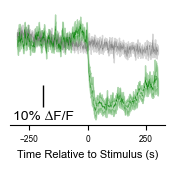

In [6]:
chow_fd = load_analysis(data_dir/'food_drop/analysis_FNC_fd2_adm571_adm551_adm569_adm567_adm543_adm546_adm484_adm480_adm485_adm445.npy', 
                        recompute= False)
chow_fd.norm = True
chow_fd.detrend =  False
chow_fd.norm_method = norm_method
chow_fd.t_prestim = 300
chow_fd.compute()

bad_fd_mice = (chow_fd.ind_peak_df_f('min', pr = False)['min ∆F/F']>-.2).droplevel(0)
bad_fd_mice = bad_fd_mice.loc[bad_fd_mice].index
mice_to_drop = np.unique(np.concatenate((bad_fd_mice, mice_to_drop)))

for i in mice_to_drop:
    chow_fd.remove_mouse(i, recompute = False)
chow_fd.compute()


fig, ax = plt.subplots(1,1, figsize = (2,1.5))
chow_fd.plot_both(ax=ax, show=False, linewidth= .2, c405 = 'gray')

vertbar = AnchoredSizeBar(ax.transData,
                           1, '10% ∆F/F', 'lower left', 
                           pad=.1,
                           color='black',
                           frameon=False,
                           size_vertical=.1)
ax.add_artist(vertbar)
ax.tick_params(left=False,labelleft=False)
ax.set_ylabel('')
ax.xaxis.label.set_fontsize(8)
for i in ax.get_xticklabels():
    i.set_fontsize(6)

sns.despine(left = True)

fig.savefig( os.path.join(first_lick_pdfs, 'chow_fd.pdf') , transparent=True, bbox_inches='tight')
fig.savefig( os.path.join(first_lick_svgs, 'chow_fd.svg') , transparent=True, bbox_inches='tight')

# Training

## load data

In [7]:
# # load training data
training = analysis(norm_method, t_dur, 
                    ds_freq = 1, ex = ex, detrend = detrend, 
                    detrend_method = detrend_method)
training.load_append_save(cohort1_data_dir/'training.npy', log=False)
training.load_append_save(cohort2_data_dir/'training.npy', log=False)

for i in mice_to_drop:
    training.remove_mouse(i, recompute = False)

training.compute()
print(f"n={training.mice.size}")

recomputing...
successful
n=7


## some methods plots

### lickometer validation

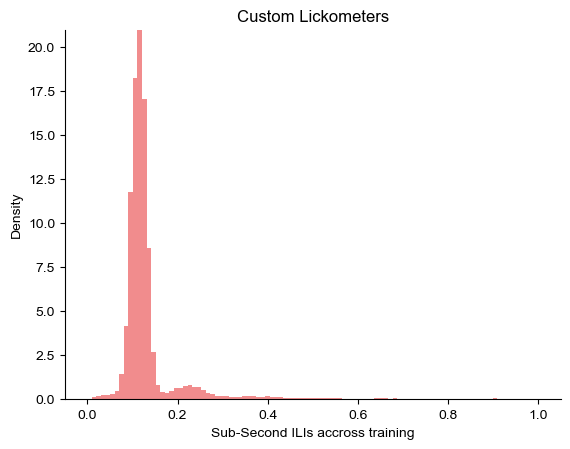

In [8]:
f = np.array([])
for i in training.raw_data:
    c = i.events['left_licks']
    c=(c[1:]-c[:-1])
    f=np.concatenate((f,c))
plt.hist(f[f<1], np.linspace(0,1, 100), alpha=.5, density = True);
plt.xlabel('Sub-Second ILIs accross training')
plt.ylabel('Density')
plt.title('Custom Lickometers')
plt.ylim(0,21)
sns.despine()

plt.savefig(os.path.join('figures', 'methods', 'pdfs', 'ili_resolutin_benchmark_custom.pdf'))
plt.savefig(os.path.join('figures', 'methods', 'svgs', 'ili_resolutin_benchmark_custom.svg'))

## Bulk analysis

In [9]:
# time lock to first lick
first_lick = time_lock_lick(training, 0, lick_field = 'left_licks')
for i in first_lick.raw_data.keys():
    ll = first_lick.raw_data.loc[i].events['left_licks']
    first_lick.raw_data.loc[i].events['left_licks'] = ll - ll[0]

### plot time lock mean traces

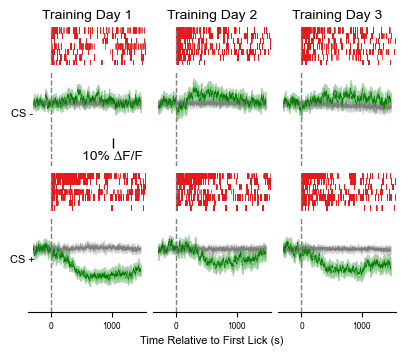

In [10]:
# let's plot both the 470 and 405 for all sessions
fig,ax = plt.subplots(4,3, figsize = (4,3.5), gridspec_kw={'height_ratios': [.4, 1,.4,1]})
ylim = (-.6, .3)

# plot cs- sessions
for i,v in enumerate(cs['-']):
    first_lick.plot_both(cond = v, ax=ax[1,i], linewidth=.2,
                       show=False, scale=1, c490 = 'g', c405='gray')
    ax[1,i].set( xlabel = '', ylabel = '',
                 ylim = ylim)
    ax[1,i].axvline(0,ls='--',c='grey', lw=1)
    ax[1,i].tick_params(left=False,bottom=False, 
                        labelleft=False,labelbottom=False)

    sns.despine(ax=ax[1,i], left = True, bottom = True)
    
# plot cs+ sessions
for i,v in enumerate(cs['+']):
    first_lick.plot_both(cond = v, ax=ax[3,i], linewidth=.2,
                       show=False, scale=1, c490 = 'g', c405='gray')
    ax[3,i].set( xlabel = '',
                 ylim = ylim, ylabel = '')
    for j in ax[3,i].get_xticklabels():
        j.set_fontsize(6)    

    ax[3,i].axvline(0,ls='--',c='grey', lw=1)
    ax[3,i].tick_params(left=False,labelleft=False)
    sns.despine(ax=ax[3,i], left = True)

ax[1,0].set_ylabel('CS -', rotation = 0, fontsize = 8)
ax[3,0].set_ylabel('CS +', rotation = 0, fontsize = 8)
ax[3,1].set_xlabel('Time Relative to First Lick (s)', fontsize = 8)

# create a size bar so we can remove the axes
vertbar = AnchoredSizeBar(ax[1,0].transData,
                           1, '10% ∆F/F', 'lower right', 
                           pad=.1,
                           color='black',
                           frameon=False,
                           size_vertical=.1)
ax[1,0].add_artist(vertbar)
xlim = ax[1,0].get_xlim()


lick_times = reindex(first_lick.raw_data.droplevel('trial').apply(lambda x: x.events['left_licks']))[0].unstack(['day','cs'])
for i in range(1,4):
    
    for j,k in enumerate(lick_times[i,'-']):
        ax[0,i-1].eventplot(k, lineoffset = j, linewidth = .5)
    ax[0,i-1].axvline(0, c = 'gray', ls = '--', lw = 1)
    ax[0,i-1].set_ylim(-.5,j + .5)
    ax[0,i-1].set_xlim(xlim)
    ax[0,i-1].set_yticks([])
    ax[0,i-1].set_xticks([])
    ax[0,i-1].set_title( f'Training Day {i}')
    ax[0,i-1].title.set_fontsize(10)
    sns.despine(ax=ax[0,i-1], left = True, bottom = True)

    
    for j,k in enumerate(lick_times[i,'+']):
        ax[2,i-1].eventplot(k, lineoffset = j, linewidth = .5)
    ax[2,i-1].axvline(0, c = 'gray', ls = '--', lw = 1)
    ax[2,i-1].set_ylim(-.5,j + .5)
    ax[2,i-1].set_xlim(xlim)
    ax[2,i-1].set_yticks([])
    ax[2,i-1].set_xticks([])
    sns.despine(ax=ax[2,i-1], left = True, bottom = True)


# format  the plot and show
fig.tight_layout(pad = .5)
plt.show()

# save the figure
fig.savefig( os.path.join(first_lick_pdfs, 'avg_training_first_lick_w_lick_raster.pdf') , 
            transparent=True, bbox_inches='tight')
fig.savefig( os.path.join(first_lick_svgs, 'avg_training_first_lick_w_lick_raster.svg') , 
            transparent=True, bbox_inches='tight')

### plot traces for each mouse

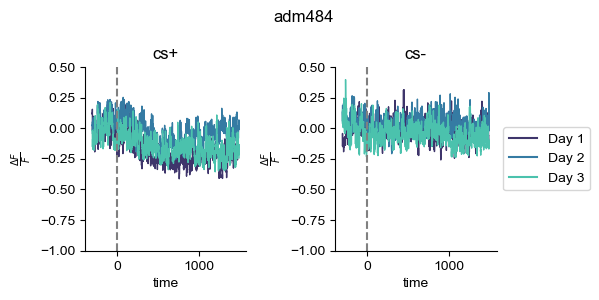

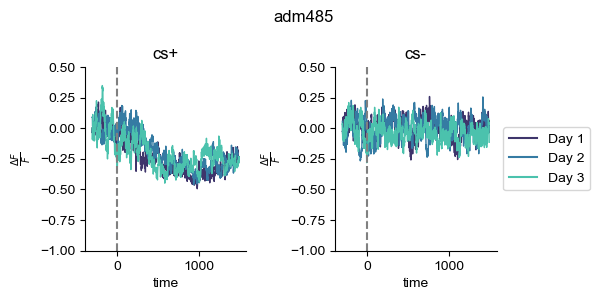

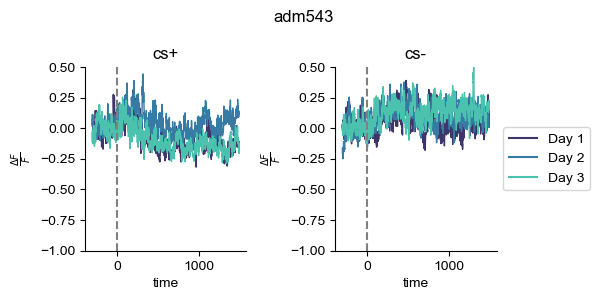

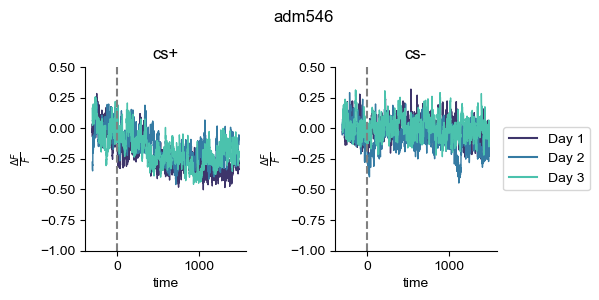

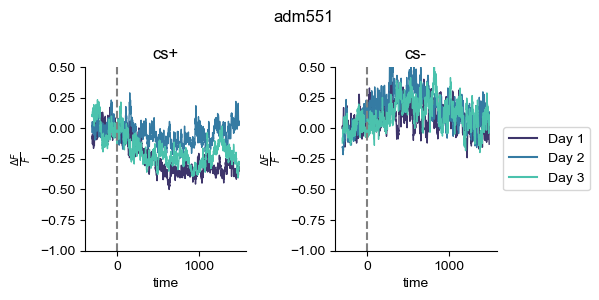

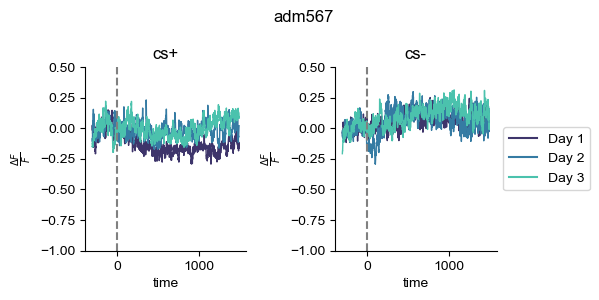

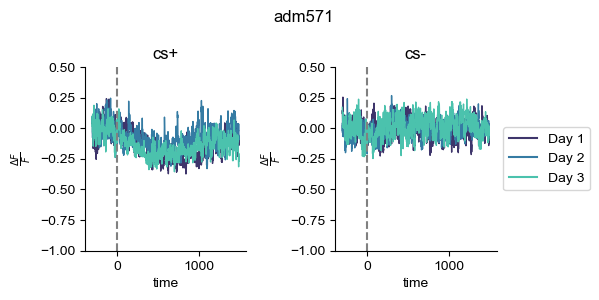

In [11]:
# # loop over the mice
for m in first_lick.mice:
    # create subplot
    fig,ax = plt.subplots(1,2, figsize = (6,3))
    
    # get mouse's cs+ licks
    tmp= first_lick.all_490.loc[:,cs['+']].loc[:,pd.IndexSlice[:,m]].droplevel('mouse', axis=1)
    tmp.index.set_names('time', inplace = True)
    tmp = tmp.stack().rename(r"$\frac{\Delta F}{F}$").reset_index()
    tmp['day'] = "Day " + tmp.cond.str.extract('(\d)')[0]
    
    #plot
    sns.lineplot(data = tmp, x='time', y= r"$\frac{\Delta F}{F}$", 
                 hue='day', ax=ax[0], palette = 'mako', legend = False, lw=1)
    sns.despine()
    ax[0].set_title('cs+')
    ax[0].set_ylim(-1,.5)
    ax[0].axvline(0, c='gray', ls = '--' )
    
    # get mouse's cs- licks
    tmp= first_lick.all_490.loc[:,cs['-']].loc[:,pd.IndexSlice[:,m]].droplevel('mouse', axis=1)
    tmp.index.set_names('time', inplace = True)
    tmp = tmp.stack().rename(r"$\frac{\Delta F}{F}$").reset_index()
    tmp['day'] = "Day " + tmp.cond.str.extract('(\d)')[0]
    
    #plot
    g = sns.lineplot(data = tmp, x='time', y= r"$\frac{\Delta F}{F}$", 
                     hue='day', ax=ax[1], palette = 'mako', lw=1)
    sns.despine()
    
    # format plot
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[1].set_title('cs-')
    ax[1].set_ylim(-1,.5)
    ax[1].axvline(0, c='gray', ls = '--' )  
    fig.suptitle(m)
    fig.tight_layout(pad=1.)
    
    # save the figure
    pdf_path = os.path.join(first_lick_pdfs, m)
    svg_path = os.path.join(first_lick_svgs, m)
    if not os.path.exists(pdf_path): os.mkdir(pdf_path)
    if not os.path.exists(svg_path): os.mkdir(svg_path)   
    fig.savefig(os.path.join(pdf_path, f'{m}_full_trace_training.pdf'))
    fig.savefig(os.path.join(svg_path, f'{m}_full_trace_training.svg'))



---

### summary plot

In [12]:
# get total licks and means for each mouse for each training day
# get all the lick data
means = first_lick.bin_avg(0, first_lick.t_endrec, pr = False)
tmp =  []

for i in first_lick.normed_data:
    tmp.append({'mouse'      : i.mouse_id,
                'total_licks': i.events['left_licks'].size,
                'meandf'     : means.loc[pd.IndexSlice[i.cond,i.mouse_id],'Mean ∆F/F'], 
                'CS'         : '+' if i.cond in cs['+'] else '-',
                'day'        : int(i.cond.split('_')[1])
               })
train_stats = pd.DataFrame(tmp)
mn_train_stats = train_stats.groupby(['mouse','CS']).mean().unstack('CS')

#### make the plot

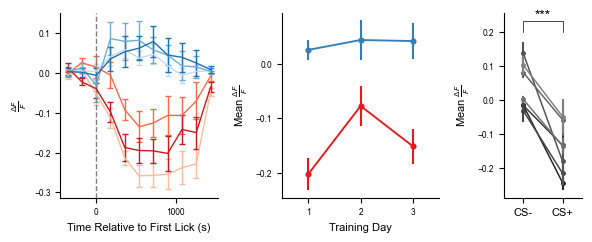

In [13]:
# create subplot
fig, ax = plt.subplots(1,3, figsize = (6,2.5), gridspec_kw={'width_ratios': [1, 1, .5]})

# plot the binned data for all sessions and color code by CS
# cs + 
for i,j in zip(cs['+'], sns.color_palette('Reds', 3)):
    first_lick.bin_plot(180, cond = i, ax = ax[0], color =j ,show=False, scale=1, capsize=2);

# cs-
for i,j in zip(cs['-'], sns.color_palette('Blues', 3)):
    first_lick.bin_plot(180, cond = i, ax = ax[0], color =j ,show=False,scale=1, capsize=2);

ax[0].axvline(0,ls='--',c='grey', lw=1)
ax[0].set_xlabel('Time Relative to First Lick (s)',fontsize = 8)
ax[0].set_ylabel(r'$\frac{\Delta F}{F}$', fontsize = 8)
ax[0].get_legend().remove()

for i in ax[0].get_yticklabels() + ax[0].get_xticklabels():
    i.set_fontsize(6)

# plot mean df/f over training
sns.pointplot(train_stats, x='day', y='meandf', hue='CS', 
              errorbar = 'se', ax=ax[1], hue_order = ['+','-'],
              scale=.5,errwidth=1.5,)

ax[1].set_ylabel(r"Mean $\frac{\Delta F}{F}$", fontsize = 8)
ax[1].set_xlabel("Training Day", fontsize = 8)
ax[1].get_legend().remove()
for i in ax[1].get_yticklabels() + ax[1].get_xticklabels():
    i.set_fontsize(6)

# plot average mean df/f for CS+ and CS- trials for each mouse
sns.pointplot(data = train_stats, x='CS', y='meandf', hue='mouse',
              errorbar='se', order=['-','+'], color='gray',
              ax=ax[2],  scale=.4,errwidth=1.5,)
ax[2].get_legend().remove()
for i in ax[2].get_yticklabels():
    i.set_fontsize(6)

# plot stats
s = st.ttest_rel(mn_train_stats['meandf']['+'], mn_train_stats['meandf']['-'])
mean_stat = pd.Series([s.statistic, s.pvalue, s.df], 
                      index=('t', 'p-value', 'df'))

plot_significance(mean_stat.loc['p-value'], ax[2], 0,1,0.2,.03)
ax[2].set_xlim(-.5,1.5)
ax[2].set_xticks((0,1))
ax[2].set_xticklabels(['CS-', 'CS+'], fontsize = 8)
ax[2].set_ylabel(r'Mean $\frac{\Delta F}{F}$', fontsize = 8)
ax[2].set_xlabel('')


# format the plot
sns.despine()
fig.tight_layout(pad = 1.)

# save the figure
fig.savefig(os.path.join(first_lick_pdfs, 'training_summary.pdf'))
fig.savefig(os.path.join(first_lick_svgs, 'training_summary.svg'))

#### stats

##### stats - full traces

,F Value,Num DF,Den DF,Pr > F,Significance
day,7.094492,2.0,12.0,9.254982e-03,**
cs,47.612366,1.0,6.0,4.577577e-04,***
time,6.033667,10.0,60.0,2.863627e-06,****
day:cs,11.669607,2.0,12.0,1.533014e-03,**
day:time,3.997228,20.0,120.0,9.360290e-07,****
cs:time,39.113563,10.0,60.0,1.387818e-22,****
day:cs:time,1.623358,20.0,120.0,5.766176e-02,ns


t   p-value   df  Corrected p-value  \
Comparison     Time                                                  
Day 1 vs Day 2 -360.0  -0.071992  0.944948  6.0           0.999558   
               -180.0  -1.382408  0.216103  6.0           0.977796   
                0.0    -0.773825  0.468418  6.0           0.999042   
                180.0  -4.562446  0.003841  6.0           0.132717   
                360.0  -3.190750  0.018818  6.0           0.416898   
                540.0  -2.596909  0.040831  6.0           0.646536   
                720.0  -2.828844  0.030003  6.0           0.560664   
                900.0  -4.170052  0.005878  6.0           0.191229   
                1080.0 -3.317487  0.016054  6.0           0.384636   
                1260.0 -3.207377  0.018428  6.0           0.416898   
                1440.0 -2.169120  0.073151  6.0           0.811982   
Day 1 vs Day 3 -360.0  -1.397441  0.211771  6.0           0.977796   
               -180.0   2.628721  0.039127  6.0           0.645741   
                0.0    -0.089624  0.931503  6.0           0.999558   
                180.0  -0.338204  0.746730  6.0           0.999558   
                360.0  -0.654296  0.537178  6.0           0.999225   
                540.0  -3.425624  0.014046  6.0           0.355013   
                720.0  -2.598476  0.040746  6.0           0.646536   
                900.0  -1.800440  0.121878  6.0           0.903620   
                1080.0 -3.599991  0.011367  6.0           0.306369   
                1260.0 -2.014966  0.090530  6.0           0.863680   
                1440.0 -1.165077  0.288208  6.0           0.983086   
Day 2 vs Day 3 -360.0  -0.655244  0.536609  6.0           0.999225   
               -180.0   2.402240  0.053132  6.0           0.715126   
                0.0     0.436809  0.677532  6.0           0.999558   
                180.0   3.683390  0.010289  6.0           0.289155   
                360.0   3.728983  0.009748  6.0           0.283280   
                540.0   1.665170  0.146932  6.0           0.932901   
                720.0   1.945615  0.099663  6.0           0.877510   
                900.0   1.861078  0.112056  6.0           0.895450   
                1080.0  0.215854  0.836252  6.0           0.999558   
                1260.0  1.268613  0.251574  6.0           0.982698   
                1440.0  1.220001  0.268237  6.0           0.982749   
CS+ vs CS-     -360.0  -0.447775  0.670029  6.0           0.999558   
               -180.0  -0.450359  0.668267  6.0           0.999558   
                0.0    -0.697841  0.511400  6.0           0.999225   
                180.0  -4.029909  0.006881  6.0           0.214682   
                360.0  -7.212457  0.000360  6.0           0.014650   
                540.0  -7.924975  0.000214  6.0           0.008996   
                720.0  -7.953677  0.000210  6.0           0.008996   
                900.0  -6.459373  0.000653  6.0           0.025143   
                1080.0 -8.246669  0.000172  6.0           0.007533   
                1260.0 -6.494711  0.000634  6.0           0.025048   
                1440.0 -5.279907  0.001865  6.0           0.068492   

                       Significance  
Comparison     Time                  
Day 1 vs Day 2 -360.0            ns  
               -180.0            ns  
                0.0              ns  
                180.0            ns  
                360.0            ns  
                540.0            ns  
                720.0            ns  
                900.0            ns  
                1080.0           ns  
                1260.0           ns  
                1440.0           ns  
Day 1 vs Day 3 -360.0            ns  
               -180.0            ns  
                0.0              ns  
                180.0            ns  
                360.0            ns  
                540.0            ns  
                720.0            ns  
                900.0            ns  
            

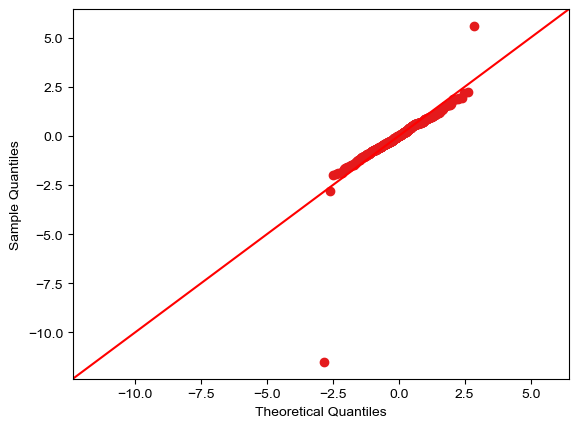

In [14]:
binned = first_lick.bin_data(180, save=False)[1].T.stack()
binned.name = 'df'
binned = reindex(binned)
binned.columns.name = ''
binned = binned.reset_index()
binned = binned.rename(columns = {'bin start (s)': 'time'})

# equivalent linear model to check for normality in qq plt
sm.qqplot(smf.ols('df ~ C(cs)*C(time)*C(day)*C(mouse)', data=binned).fit().resid, fit=True, line='45');
anova_train_trace = pd.DataFrame(AnovaRM(binned, 'df', subject='mouse',within = ['day','cs','time']).fit().summary().tables[0])
anova_train_trace['Significance'] = anova_train_trace['Pr > F'].apply(check_significance)

# compare cs responses averaged accross days at each time point
bd =   binned.groupby(['cs', 'mouse', 'time']).df.mean().unstack('cs')
pvm =  (bd.groupby('time')
          .apply(lambda x: st.ttest_rel(x['+'], x['-']))
          .apply(lambda x: pd.Series(list(x) + [x.df], index = ('t','p-value', 'df')))
       )
# compare day responses averaged accross cs's at each time point
bd =   binned.groupby(['day', 'mouse', 'time']).df.mean().unstack('day')
d1v2 =  (bd.groupby('time')
           .apply(lambda x: st.ttest_rel(x[1], x[2]))
           .apply(lambda x: pd.Series(list(x) + [x.df], index = ('t','p-value', 'df')))
        )
d1v3 =  (bd.groupby('time')
           .apply(lambda x: st.ttest_rel(x[1], x[3]))
           .apply(lambda x: pd.Series(list(x) + [x.df], index = ('t','p-value', 'df')))
        )
d2v3 =  (bd.groupby('time')
           .apply(lambda x: st.ttest_rel(x[2], x[3]))
           .apply(lambda x: pd.Series(list(x) + [x.df], index = ('t','p-value', 'df')))
        )

# compile into one dataframe
stats_train_trace = pd.concat({'Day 1 vs Day 2': d1v2 , 
                               'Day 1 vs Day 3': d1v3 , 
                               'Day 2 vs Day 3': d2v3 , 
                               'CS+ vs CS-': pvm})
# adjust p-values
stats_train_trace['Corrected p-value'] = multipletests(stats_train_trace['p-value'], method='holm-sidak')[1]
stats_train_trace.index = stats_train_trace.index.set_names(["Comparison", "Time"])
stats_train_trace['Significance'] = stats_train_trace['Corrected p-value'].apply(check_significance)

display(anova_train_trace, stats_train_trace)

# store tables
train_fig_stats.update({'e_train_trace_anova': anova_train_trace,
                        'e_train_trace_stats': stats_train_trace})

##### stats - average mean ∆F/F per day

In [15]:
# check sphericity assumption for 3 level within subject factor day
pg.sphericity(train_stats, dv='meandf',within='day', subject='mouse')

SpherResults(spher=True, W=2089.102558178462, chi2=-38.222449273702, dof=2, pval=1.0)

In [16]:
# check for normality
shapiro = (train_stats.groupby(['day','CS']).meandf
                      .apply(lambda x: st.shapiro(x))
                      .apply(lambda x: pd.Series(x, index = ('W', 'p-value')))
          )

# compute anova
mean_anova = pg.rm_anova(data = train_stats, dv='meandf', within = ['day','CS'], subject = 'mouse')
mean_anova['Significance'] = mean_anova['p-unc'].apply(check_significance) # mauchly's test was negative so using the uncorrected p-value

# get difference between cs+ and cs- mean response on each day and compare between days
meandf = train_stats.set_index(['mouse','CS','day']).meandf.unstack('CS')
df = (meandf['+'] - meandf['-']).unstack("day").T
s = st.ttest_rel(df.loc[1], df.loc[2])
d1v2_diff = pd.Series([s.statistic, s.pvalue, s.df], index = ('t', 'p-value', 'df')).to_frame().T
s = st.ttest_rel(df.loc[1], df.loc[3])
d1v3_diff = pd.Series([s.statistic, s.pvalue, s.df], index = ('t', 'p-value', 'df')).to_frame().T
s = st.ttest_rel(df.loc[3], df.loc[2])
d2v3_diff = pd.Series([s.statistic, s.pvalue, s.df], index = ('t', 'p-value', 'df')).to_frame().T

# compare mean response (mean cs+ + mean cs-/2) between days
df = train_stats.groupby(['day','mouse']).meandf.mean()
s = st.ttest_rel(df.loc[1], df.loc[2])
d1v2 = pd.Series([s.statistic, s.pvalue, s.df], index = ('t', 'p-value', 'df')).to_frame().T
s = st.ttest_rel(df.loc[1], df.loc[3])
d1v3 = pd.Series([s.statistic, s.pvalue, s.df], index = ('t', 'p-value', 'df')).to_frame().T
s = st.ttest_rel(df.loc[3], df.loc[2])
d2v3 = pd.Series([s.statistic, s.pvalue, s.df], index = ('t', 'p-value', 'df')).to_frame().T

# compile into a table
mean_stat_perd = pd.concat({'Day 1 vs Day 2': d1v2, 
                            'Day 1 vs Day 3': d1v3, 
                            'Day 2 vs Day 3': d2v3, 
                            'Day 1 vs Day 2 CS+ - CS-': d1v2_diff, 
                            'Day 1 vs Day 3 CS+ - CS-': d1v3_diff, 
                            'Day 2 vs Day 3 CS+ - CS-': d2v3_diff, 
                            }, names = ['Comparison']).droplevel(1)

# adjust p-values
mean_stat_perd['Corrected p-value'] = multipletests(mean_stat_perd['p-value'], method='holm-sidak')[1]
mean_stat_perd['Significance'] = mean_stat_perd['Corrected p-value'].apply(check_significance)

display(shapiro, mean_anova, mean_stat_perd)

# store tables
train_fig_stats.update({"f_train_mean_anova": mean_anova,
                        "f_train_mean_stats": mean_stat_perd})

W   p-value
day CS                    
1   +   0.890135  0.275370
    -   0.828134  0.076820
2   +   0.950294  0.732373
    -   0.976362  0.940087
3   +   0.916963  0.446176
    -   0.875386  0.206742

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps,Significance
0,day,0.036042,2,12,0.018021,7.353085,0.008230,0.016387,0.140458,0.759630,**
1,CS,0.344287,1,6,0.344287,47.349402,0.000465,0.000465,0.609524,1.000000,***
2,day * CS,0.020919,2,12,0.010460,11.104472,0.001863,0.004601,0.086629,0.785931,**


,t,p-value,df,Corrected p-value,Significance
Comparison,,,,,
Day 1 vs Day 2,-3.501412,0.012804,6.0,0.062403,ns
Day 1 vs Day 3,-2.690986,0.036005,6.0,0.104174,ns
Day 2 vs Day 3,-1.748753,0.130916,6.0,0.244693,ns
Day 1 vs Day 2 CS+ - CS-,-6.519818,0.000621,6.0,0.003720,**
Day 1 vs Day 3 CS+ - CS-,-1.273338,0.250004,6.0,0.250004,ns
Day 2 vs Day 3 CS+ - CS-,-2.956156,0.025409,6.0,0.097828,ns


##### stats - average mean ∆F/F comparison

In [17]:
mean_stat = mean_stat.rename("CS+ vs CS-").to_frame().T
mean_stat['Significance'] = check_significance(mean_stat['p-value'].values[0])
display(mean_stat)

train_fig_stats.update({"g_mean_stat": mean_stat})

,t,p-value,df,Significance
CS+ vs CS-,-6.88109,0.000465,6.0,***


## bout level analyses

Here we're interested in whether or not we can identify faster dynamics time-locked to the initiation of lick bouts. First we need to identify the onsets of lick bouts.

In [14]:
# load training data
training = analysis(norm_method, t_dur, norm = False,
                    ds_freq = ds_freq, ex = ex, detrend = detrend, 
                    detrend_method = detrend_method)
training.load_append_save(cohort1_data_dir/'training.npy', log=False)
training.load_append_save(cohort2_data_dir/'training.npy', log=False)
for i in mice_to_drop:
    training.remove_mouse(i, recompute = False)
training.compute()

# compute lick bout times for training
for i,v in training.raw_data.items():
    l = training.raw_data.loc[i].events['left_licks'] 
    ili = np.append(bout_thresh + 1, l[1:] - l[:-1])
    training.raw_data.loc[i].events['left_bouts'] = l[ili > bout_thresh]

# compute lick rates during training
lr_train = get_lick_rate(training, 'left_licks', sigma = .4, win = 2)

recomputing...
successful


In [15]:
orig_training = deepcopy(training) # keep a version before detrending

# remove timestamps corresponding to datapoints that will be lost to the moving average
old_t = training.all_490.index.values
new_t = old_t[int(ds_freq * w_rad):-int(ds_freq *w_rad)]

# estimate the baseline with a moving average
bl = training.all_490.apply(lambda x: pd.Series(signal.convolve(x, kernel, mode='valid'), index = new_t), axis=0)

# update the end and start time fields in the analysis object
training.t_prestim = -new_t[0]
training.t_endrec = new_t[-1]
training.all_490 = training.all_490.loc[bl.index]

# normalize relative to the baseline
training.all_490 = (training.all_490.copy() - bl)/bl

# #z-score ∆F/Fs relative to baseline activity for each session
training.all_490 = (training.all_490 - training.all_490.loc[:0].mean(axis=0))/training.all_490.loc[:0].std(axis=0)

In [16]:
# check how many bouts we are removing due to moving average
def bouts_lost(x):
    prev_good = x.events['left_bouts']<(old_t[-1] - w_rad)
    now_bad = x.events['left_bouts']>(training.t_endrec - w_rad)
    return (now_bad & prev_good).sum()

max_rm_bouts = training.raw_data.map(bouts_lost).max()
mn_rm_bouts = training.raw_data.map(bouts_lost).mean()

print('max removed bouts:', max_rm_bouts , 
      '\nmean number bouts removed:', mn_rm_bouts)

max removed bouts: 1 
mean number bouts removed: 0.30952380952380953


### (supplemental) - demo of detrending method

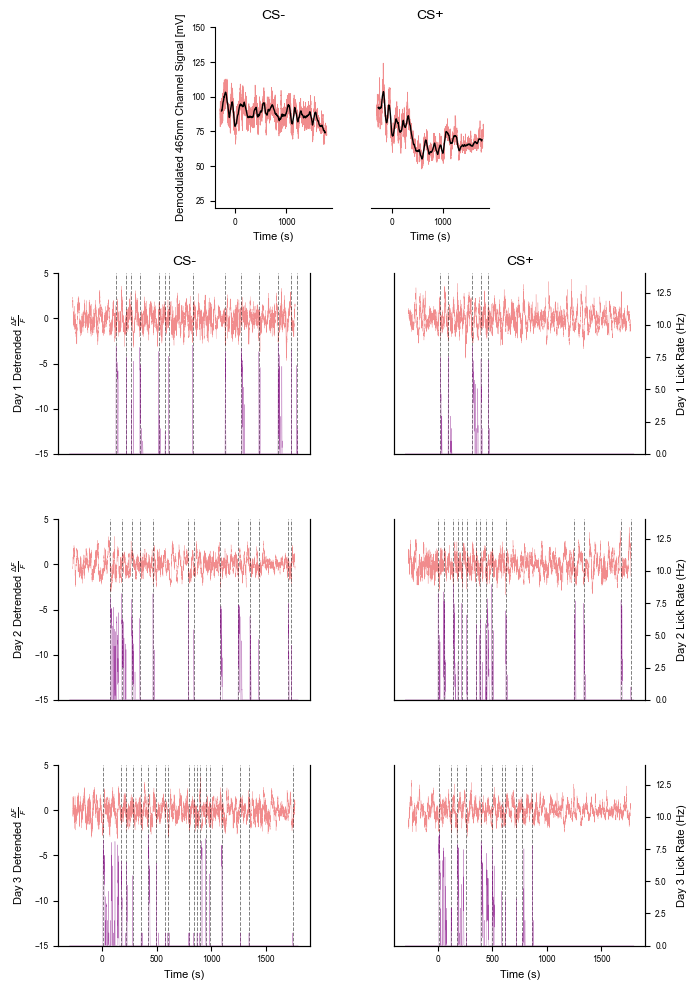

In [17]:
# create the plot
fig = plt.figure(figsize = (7,10))

# plot example model fit for a CS- session
m = 'adm485' # example mouse
ylim = (20, 150)
ax = fig.add_subplot(442)
ax.plot(orig_training.all_490['training_3_am', m], alpha = .5, lw = .5)
ax.plot( bl['training_3_am', m], c = 'k', lw = 1)
ax.set_ylabel(r'Demodulated 465nm Channel Signal [mV]', fontsize=8)
ax.set_xlabel('Time (s)', fontsize=8)
ax.set_title("CS-", fontsize=10)
ax.set_ylim(ylim)
sns.despine()
for i in ax.get_xticklabels() + ax.get_yticklabels():
    i.set_fontsize(6)

# plot example model fit for CS+ session
ax = fig.add_subplot(443)
ax.plot(orig_training.all_490['training_3_pm',m], alpha = .5, lw = .5)
ax.plot(bl['training_3_pm', m], c = 'k', lw = 1)
ax.set_yticks([])
ax.set_xlabel('Time (s)', fontsize=8)
ax.set_ylim(ylim)
ax.set_title("CS+", fontsize=10)
sns.despine(ax = ax, left = True)
for i in ax.get_xticklabels() + ax.get_yticklabels():
    i.set_fontsize(6)
fig.tight_layout(pad = 1.)


# plot detrended CS+ data on top of lick rate
# day 1
# CS-
ylim  = (-15,5)
lylim = (0,14)
ax = fig.add_subplot(423)
ax.plot(training.all_490['training_1_am',m], alpha=.5,  lw = .2)
ax2 = ax.twinx()
ax2.plot(lr_train['training_1_am',m],  c = 'purple', alpha=.7, lw = .2)
ax.vlines(training.raw_data.loc['training_1_am',m,0].events['left_bouts'], ylim[0], ylim[1], lw=.7, color='k', alpha=.5, ls = '--')
ax.set_ylim(ylim)
ax.set_xticks([])
ax.set_title("CS-",  fontsize=10)
ax.set_ylabel(r"Day 1 Detrended $\frac{\Delta F}{F}$", fontsize=8)
ax2.set_ylim(lylim)
ax2.set_yticks([])
for i in ax.get_xticklabels() + ax.get_yticklabels()+  ax2.get_yticklabels():
    i.set_fontsize(6)
    
sns.despine(ax = ax, top=True, right=False)
sns.despine(ax = ax2, top=True, right=False)


#CS+
ax = fig.add_subplot(424)
ax.plot(training.all_490['training_1_pm',m], alpha=.5,  lw = .2)
ax2 = ax.twinx()
ax2.plot(lr_train['training_1_pm',m], c = 'purple', alpha=.7, lw = .2)
ax.vlines(training.raw_data.loc['training_1_pm',m,0].events['left_bouts'], ylim[0], ylim[1], lw=.7, color='k', alpha=.5, ls = '--')
ax.set_ylim(ylim)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title("CS+", fontsize=10)
ax2.set_ylim(lylim)
ax2.set_ylabel("Day 1 Lick Rate (Hz)", fontsize=8)
for i in ax.get_xticklabels() + ax.get_yticklabels()+  ax2.get_yticklabels():
    i.set_fontsize(6)
sns.despine(ax = ax, top=True, right=False)
sns.despine(ax = ax2, top=True, right=False)

# day 2
# CS-
ax = fig.add_subplot(425)
ax.plot(training.all_490['training_2_pm',m], alpha=.5,  lw = .2)
ax2 = ax.twinx()
ax2.plot(lr_train['training_2_pm',m],  c = 'purple', alpha=.7, lw = .2)
ax.vlines(training.raw_data.loc['training_2_pm',m,0].events['left_bouts'], ylim[0], ylim[1], lw=.7, color='k', alpha=.5, ls = '--')
ax.set_ylim(ylim)
ax.set_xticks([])
ax.set_ylabel(r"Day 2 Detrended $\frac{\Delta F}{F}$", fontsize=8)
ax2.set_ylim(lylim)
ax2.set_yticks([])
for i in ax.get_xticklabels() + ax.get_yticklabels()+  ax2.get_yticklabels():
    i.set_fontsize(6)
sns.despine(ax = ax, top=True, right=False)
sns.despine(ax = ax2, top=True, right=False)


#CS+
ax = fig.add_subplot(426)
ax.plot(training.all_490['training_2_am',m], alpha=.5,  lw = .2)
ax2 = ax.twinx()
ax2.plot(lr_train['training_2_am',m], c = 'purple', alpha=.7, lw = .2)
ax.vlines(training.raw_data.loc['training_2_am',m,0].events['left_bouts'], ylim[0], ylim[1], lw=.7, color='k', alpha=.5, ls = '--')
ax.set_ylim(ylim)
ax.set_yticks([])
ax.set_xticks([])
ax2.set_ylim(lylim)
ax2.set_ylabel("Day 2 Lick Rate (Hz)", fontsize=8)
for i in ax.get_xticklabels() + ax.get_yticklabels()+  ax2.get_yticklabels():
    i.set_fontsize(6)
sns.despine(ax = ax, top=True, right=False)
sns.despine(ax = ax2, top=True, right=False)

# day 3
# CS-
ax = fig.add_subplot(427)
ax.plot(training.all_490['training_3_am',m], alpha=.5,  lw = .2)
ax2 = ax.twinx()
ax2.plot(lr_train['training_3_am',m], c = 'purple', alpha=.7, lw = .2)
ax.vlines(training.raw_data.loc['training_3_am',m,0].events['left_bouts'], ylim[0], ylim[1], lw=.7, color='k', alpha=.5, ls = '--')
ax.set_ylim(ylim)
ax.set_xlabel("Time (s)", fontsize=8)
ax.set_ylabel(r"Day 3 Detrended $\frac{\Delta F}{F}$", fontsize=8)
ax2.set_ylim(lylim)
ax2.set_yticks([])
for i in ax.get_xticklabels() + ax.get_yticklabels() +  ax2.get_yticklabels():
    i.set_fontsize(6)
sns.despine(ax = ax, top=True, right=False)
sns.despine(ax = ax2, top=True, right=False)


#CS+
ax = fig.add_subplot(428)
ax.plot(training.all_490['training_3_pm',m], alpha=.5,  lw = .2)
ax2 = ax.twinx()
ax2.plot(lr_train['training_3_pm',m],  c = 'purple', alpha=.7, lw = .2)
ax.vlines(training.raw_data.loc['training_3_pm',m,0].events['left_bouts'], ylim[0], ylim[1], lw=.7, color='k', alpha=.5, ls = '--')
ax.set_ylim(ylim)
ax.set_yticks([])
ax.set_xlabel("Time (s)", fontsize=8)
ax2.set_ylim(lylim)
ax2.set_ylabel("Day 3 Lick Rate (Hz)", fontsize=8)
for i in ax.get_xticklabels() + ax.get_yticklabels()+  ax2.get_yticklabels():
    i.set_fontsize(6)
sns.despine(ax = ax, top=True, right=False)
sns.despine(ax = ax2, top=True, right=False)


# format plot
fig.tight_layout(h_pad = 1, w_pad = .001)

# save the figure
fig.savefig(os.path.join('figures', 'methods', 'pdfs', 'supplement_detrending.pdf'))
fig.savefig(os.path.join('figures', 'methods', 'svgs', 'supplement_detrending.svg'))

### extracting peri-lick bout activity

In [18]:
# get peri-bout activity for all bouts
bn= training.raw_data.apply(lambda x: get_bn(x, 'left_licks', 'left_bouts'))
for i in training.raw_data.index:
    # only include bouts with more than one lick
    l = training.raw_data[i].events['left_bouts']
    valid = (bn.loc[i]>1) & (l<(training.t[-1] - peri_window - 1))
    training.raw_data[i].events['valid_bouts'] = l[valid]
    
peri_bout = peri_event(training, 'valid_bouts', peri_window, norm = peri_bout_norm_train)
peri_bout = reindex(peri_bout).loc[[1,3]]
mn_peri_bout = peri_bout.groupby(['day','cs','mouse']).mean()

### randomize

In [19]:
# simmulate random lick bouts and get corresponding peri bout activity
np.random.seed(32)
ctl = []

with tqdm(total = niters_rand) as pbar:
    def randomize_bouts(pid):
        global ctl_mn
        global training
        
        end_lim = training.all_490.index[-1]-peri_window-1
        for i,v in training.raw_data.items():
            # create an array of times to sample
            ts = np.arange(0, end_lim + 1/100, step = 1/100)
            n = v.events['valid_bouts'].size # get the number of bouts to sample
            rand_evs = np.empty((n,))

            for j in range(n):
                #choose a bout onset time from available times
                rand_evs[j] = np.random.choice(ts)
                # remove the selected time from avavilable times array
                # as well as any times within the bout threshold
                ts = ts[np.abs(ts - rand_evs[j]) > bout_thresh]  
            
            #save randomized bouts
            training.raw_data.loc[i].events[f'rand_bouts_{pid}'] = np.sort(rand_evs) 
            
        # get peri-bout data for random bouts and compute the mean response
        _d = peri_event(training, f'rand_bouts_{pid}', peri_window,norm = peri_bout_norm_test)
        _d = _d.groupby(['cond','mouse'], axis=1).mean()
        ctl.append(_d)

    with ThreadPoolExecutor(max_workers=2) as pool:
        futures = [pool.submit(randomize_bouts, i) for i in range(niters_rand)]
        for future in as_completed(futures):
            pbar.update(1)

ctl = reindex(pd.concat(dict(zip(range(len(ctl)), ctl)), 
                        axis=1, names = ['event']))
ctl_mn = ctl.groupby(['day','cs','mouse']).mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.97it/s]


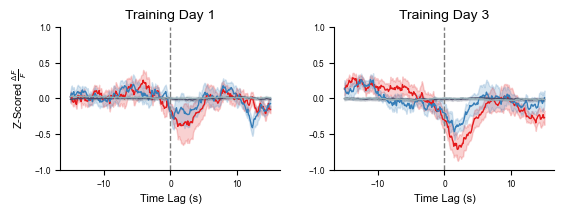

In [20]:
tmp = mn_peri_bout.stack().rename('df')
tmp2 = ctl_mn.stack().rename('df')


fig, ax = plt.subplots(1,2, figsize = (6,2.5))
for i,j in enumerate([1,3]):
    sns.lineplot(data = tmp.loc[j].reset_index(), x='time', y='df', 
                 errorbar = 'se',  hue='cs', ax = ax[i], lw = 1, legend = False)
    sns.lineplot(data = tmp2.loc[j].reset_index(), x='time', y='df', 
                 errorbar = 'se',  hue='cs', ax = ax[i], lw = 1,
                legend=False, palette='bone')
    ax[i].set_ylim(-1,1)
    ax[i].set_xlabel('Time Lag (s)', fontsize = 8)
    ax[i].axvline(0, c='gray',ls ='--', lw=1)
    for k in ax[i].get_xticklabels() + ax[i].get_yticklabels():
        k.set_fontsize(6)
    ax[i].set_title(f'Training Day {j}', fontsize=10)
    
ax[0].set_ylabel(r'Z-Scored $\frac{\Delta F}{F}$', fontsize = 8)
ax[1].set_ylabel('')
sns.despine()
fig.tight_layout(pad=2.)
fig.savefig(os.path.join(peri_stim_pdfs_train , 'training_all.pdf'), bbox_inches = 'tight')
fig.savefig(os.path.join(peri_stim_svgs_train , 'training_all.svg'), bbox_inches = 'tight')

#### individual mice

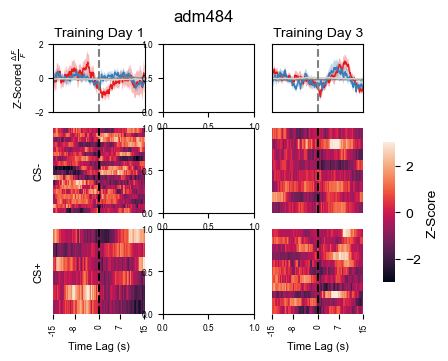

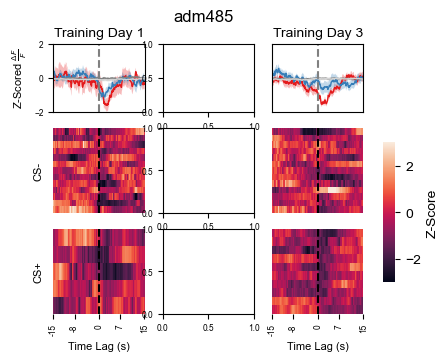

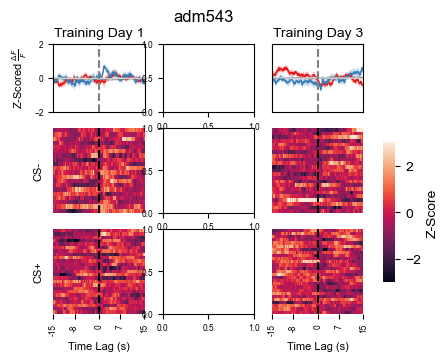

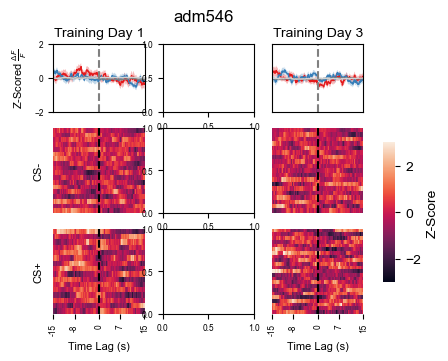

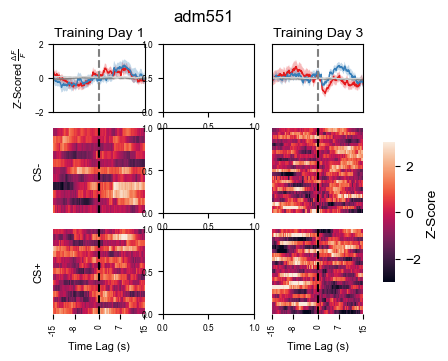

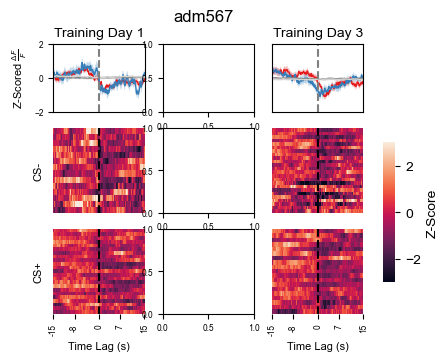

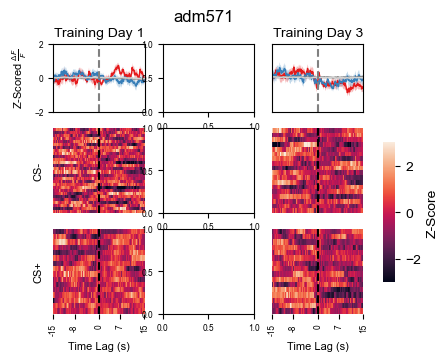

In [22]:
for i in mn_peri_bout.index.get_level_values('mouse').unique():
    fig, ax = plot_peri(peri_bout.swaplevel('day','mouse').loc[i].swaplevel('day','cs'), 
                          ctl = ctl.swaplevel('day','mouse').loc[i].swaplevel('day','cs'),
                          save=False, vmin = -3, vmax=3, ylim = (-2,2),
                          figsize=(4,3.5));
    for l in range(3):
        for j in range(3):
            for k in ax[l,j].get_xticklabels() + ax[l,j].get_yticklabels():
                k.set_fontsize(6)
            ax[l,j].xaxis.label.set_fontsize(8)
            ax[l,j].yaxis.label.set_fontsize(8)
            ax[l,j].title.set_fontsize(10)
    fig.suptitle(i)
    os.makedirs(os.path.join(peri_stim_pdfs_train , i), exist_ok=True)  
    os.makedirs(os.path.join(peri_stim_svgs_train , i), exist_ok=True)   

    fig.savefig(os.path.join(peri_stim_pdfs_train , i,  'training_all.pdf'), bbox_inches = 'tight')
    fig.savefig(os.path.join(peri_stim_svgs_train , i, 'training_all.svg'), bbox_inches = 'tight')

#### stats

##### stats - compare lick bouts to be sure the corresponding bout numbers for all bout triggered averages are comparable

In [30]:
nb_train =  peri_bout.groupby(['day','cs','mouse']).size().rename('nb').reset_index()
nb_train = (nb_train.groupby(['day','cs']).nb.mean().round(2).astype(str) + ' ± '\
            + nb_train.groupby(['day','cs']).nb.sem().round(2).astype(str))
display(nb_train.unstack('cs'))
train_fig_stats.update({'h_n_train_bouts': nb_train})

cs,+,-
day,,
1,15.14 ± 2.87,17.43 ± 2.14
3,18.14 ± 2.35,18.29 ± 2.24


##### stats - compare bout triggered averages

In [23]:
peri_binned = bin_peri_bout(peri_bout,1).stack().rename('df').reset_index()

###### illustration of splines

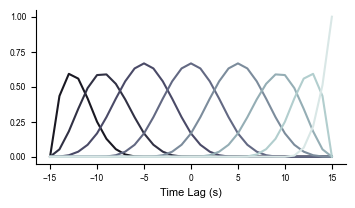

In [24]:
from patsy import dmatrix
x=np.sort(peri_binned.bins.unique())
splines = dmatrix("bs(x, df=8, degree=3, include_intercept=False) -1", 
                  {"x":x}, return_type="dataframe").values
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.set_prop_cycle(color=sns.color_palette("bone",8))
ax.plot(x, splines, label = np.arange(8))
ax.set_xlabel("Time Lag (s)", fontsize=8)

for i in ax.get_xticklabels() + ax.get_yticklabels():
    i.set_fontsize(6)
sns.despine()
plt.savefig(os.path.join('figures', 'methods', 'pdfs', 'splines.pdf'))
plt.savefig(os.path.join('figures', 'methods', 'svgs', 'splines.svg'))

R[write to console]: boundary (singular) fit: see help('isSingular')



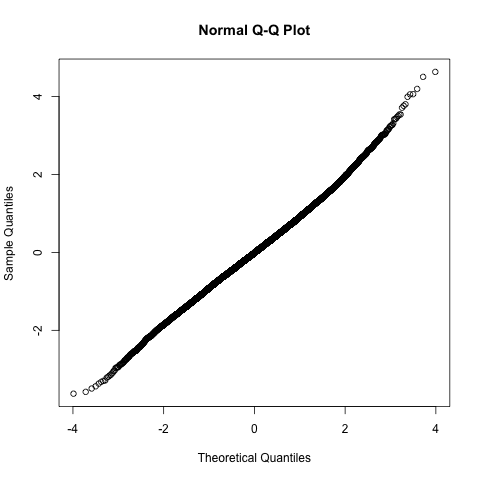

In [30]:
%%R -i peri_binned -o all_anova -o all_model
m <- lmer('df ~ 1 +  factor(day)*bs(bins, df=8, degree=3)*factor(cs)+ (1 + bs(bins, df=8, degree=3)|mouse)', data = peri_binned)
all_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
all_anova <- anova(m)

In [31]:
all_anova['Significance'] = all_anova['Pr(>F)'].apply(check_significance)
all_model['Significance'] = all_model['Pr(>|t|)'].apply(check_significance)

display(all_anova, all_model)
train_fig_stats.update({'h_peri_bout_anovas': all_anova,
                        'h_peri_bout_model':  all_model
                       })

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F),Significance
factor(day),2.789776,2.789776,1,14790.094002,3.122276,7.724949e-02,ns
"bs(bins, df = 8, degree = 3)",31.111383,3.888923,8,9.801792,4.352425,1.749462e-02,*
factor(cs),0.007967,0.007967,1,14712.310660,0.008917,9.247685e-01,ns
"factor(day):bs(bins, df = 8, degree = 3)",60.819393,7.602424,8,14504.710084,8.508520,1.271790e-11,****
factor(day):factor(cs),2.311186,2.311186,1,14608.205671,2.586645,1.077900e-01,ns
"bs(bins, df = 8, degree = 3):factor(cs)",27.302419,3.412802,8,14252.431160,3.819558,1.702830e-04,***
"factor(day):bs(bins, df = 8, degree = 3):factor(cs)",32.233694,4.029212,8,13922.777448,4.509434,1.729150e-05,****


,Estimate,Std. Error,df,t value,Pr(>|t|),Significance
(Intercept),0.062521,0.086537,85.700281,0.722475,0.471969,ns
factor(day)3,0.012844,0.112509,14395.945092,0.114158,0.909114,ns
"bs(bins, df = 8, degree = 3)1",0.051969,0.168983,165.256998,0.307541,0.758819,ns
"bs(bins, df = 8, degree = 3)2",-0.159132,0.140288,63.476046,-1.134329,0.260922,ns
"bs(bins, df = 8, degree = 3)3",0.212966,0.140867,84.769356,1.511822,0.134298,ns
"bs(bins, df = 8, degree = 3)4",-0.339520,0.189895,11.580453,-1.787934,0.099958,ns
"bs(bins, df = 8, degree = 3)5",-0.046805,0.200552,12.391909,-0.233380,0.819277,ns
"bs(bins, df = 8, degree = 3)6",0.062041,0.166489,31.290812,0.372642,0.711927,ns
"bs(bins, df = 8, degree = 3)7",-0.521157,0.181506,21.789065,-2.871288,0.008925,**
"bs(bins, df = 8, degree = 3)8",-0.116967,0.118383,132.326375,-0.988039,0.324937,ns


In [ ]:
with pd.ExcelWriter(os.path.join(stat_save_loc,'train_stats.xlsx')) as writer:  
    for k,v in train_fig_stats.items():
        v.to_excel(writer, sheet_name=k)

### within session

In [21]:
nbins = 3

#### bin by time

In [37]:
# in case we want to bin by time relative to the infusion start
tmp = (training.raw_data.apply(lambda x: x.events['valid_bouts'] - x.events['left_licks'][0])
                  .apply(lambda x: pd.Series(x, pd.Index(np.arange(x.size), name = 'event')))
                  .stack()
)
peri_bout_t = peri_bout.copy()
peri_bout_t['bout_time'] = reindex(tmp.droplevel('trial'))[0]
peri_bout_t = peri_bout_t.set_index('bout_time', append = True).droplevel('event')

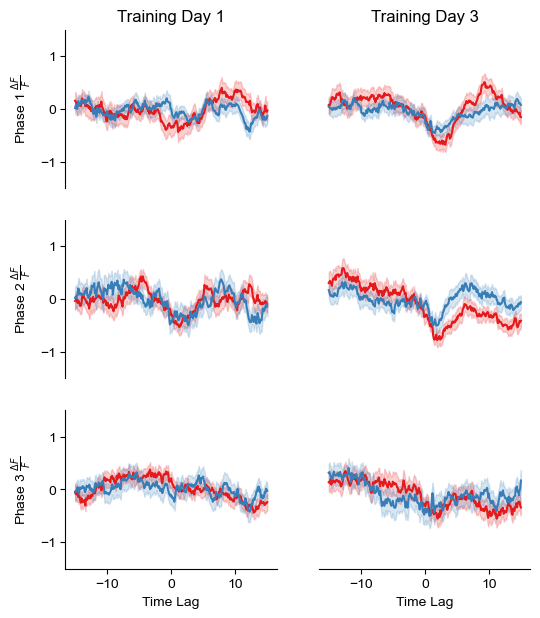

In [38]:
tmp = peri_bout_t.stack().rename("df").reset_index()
tmp['binned_norm_event'] = pd.cut(tmp.bout_time, bins=nbins)

fig, ax = plt.subplots(nbins,2, figsize = (6,7))
for i,v in enumerate(tmp.binned_norm_event.unique()):
    g = sns.lineplot(tmp.loc[(tmp.day == 1) & (tmp.binned_norm_event == v)],  
                     legend = False, x = 'time', y = 'df', hue = 'cs', ax = ax[i,0], 
                     errorbar = 'se')
    ax[i,0].set_ylim(-1.5,1.5)
    ax[i,0].set_ylabel("Phase " + f"{i+1} " + r"$\frac{\Delta F}{F}$")
    if i<nbins-1: 
        ax[i,0].set_xlabel("")
        ax[i,0].set_xticks([])
        sns.despine(ax = ax[i,0], bottom = True)
    else: 
        ax[i,0].set_xlabel("Time Lag")
        sns.despine(ax = ax[i,0])
    
for i,v in enumerate(tmp.binned_norm_event.unique()):
    g = sns.lineplot(tmp.loc[(tmp.day == 3) & (tmp.binned_norm_event == v)],  
                     x = 'time', y = 'df', hue = 'cs', ax = ax[i,1], 
                     errorbar = 'se', legend = False)
    ax[i,1].set_ylim(-1.5,1.5)
    ax[i,1].set_ylabel("")
    ax[i,1].set_yticks([])
    sns.despine(ax = ax[i,1], left = True, bottom = True)
    if i<nbins-1: 
        ax[i,1].set_xlabel("")
        ax[i,1].set_xticks([])
        sns.despine(ax = ax[i,1], left = True, bottom = True)
    else: 
        ax[i,1].set_xlabel("Time Lag")
        sns.despine(ax = ax[i,1], left = True)
        
ax[0,0].set_title("Training Day 1")
ax[0,1].set_title("Training Day 3")

# fig.savefig("within_sess_training_bin_time_cs_comp.svg")

##### stats

In [39]:
tmp2 = tmp.groupby(['day','cs','mouse','time','bout_time']).df.mean()
tmp2 = tmp2.reset_index('bout_time')
tmp2['event'] = tmp2['bout_time'].astype(str)
tmp2 = tmp2.set_index('event', append=True).df
tmp2 = tmp2.unstack('time')
tmp2 = bin_peri_bout(tmp2,1).stack().rename("df").reset_index()
tmp2['phase'] = pd.cut(tmp2.event.astype(float), bins=nbins).astype(str)
d1 = tmp2.loc[tmp2.day ==1]
d3 = tmp2.loc[tmp2.day ==3]

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: boundary (singular) fit: see help('isSingular')



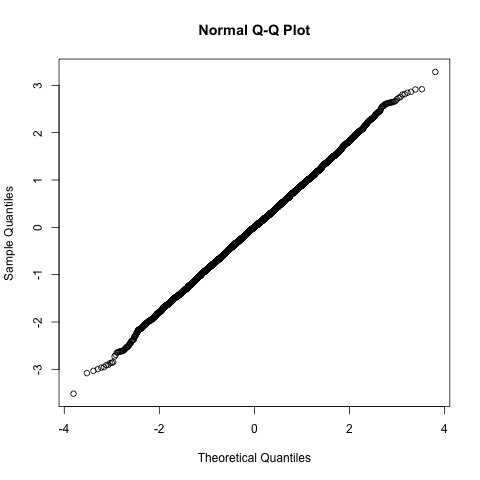

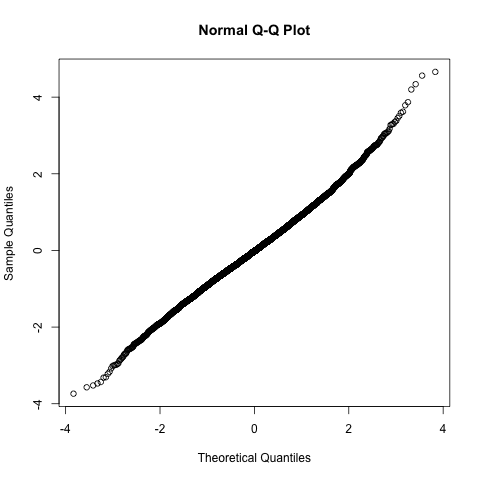

In [41]:
%%R -i d1 -i d3 -o d1_anova -o d1_model -o d3_anova -o d3_model
m <- lmer('df ~ 1 +  factor(cs)*bs(bins, df=8, degree=3)*factor(phase)+ (1 + bs(bins, df=8, degree=3)|mouse)', data = d1)
d1_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
d1_anova <- anova(m)


m <- lmer('df ~ 1 +  factor(cs)*bs(bins, df=8, degree=3)*factor(phase)+ (1 + bs(bins, df=8, degree=3)|mouse)', data = d3)
d3_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
d3_anova <- anova(m)

In [42]:
display(d1_anova)
display(d1_model)
display(d3_anova)
display(d3_model)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
factor(cs),0.839689,0.839689,1,6982.088306,1.027356,3.108156e-01
"bs(bins, df = 8, degree = 3)",30.696426,3.837053,8,8.910596,4.694620,1.679515e-02
factor(phase),1.290132,0.645066,2,6982.098463,0.789236,4.542323e-01
"factor(cs):bs(bins, df = 8, degree = 3)",9.396122,1.174515,8,4005.662592,1.437015,1.755386e-01
factor(cs):factor(phase),0.318736,0.159368,2,6982.087961,0.194986,8.228506e-01
"bs(bins, df = 8, degree = 3):factor(phase)",60.790987,3.799437,16,5602.464399,4.648596,1.983945e-09
"factor(cs):bs(bins, df = 8, degree = 3):factor(phase)",33.139700,2.071231,16,6130.990870,2.534144,6.670206e-04


,Estimate,Std. Error,df,t value,Pr(>|t|)
(Intercept),0.093971,0.120179,6982.112672,0.781922,0.434287
factor(cs)+,-0.017778,0.187285,6982.066081,-0.094923,0.924379
"bs(bins, df = 8, degree = 3)1",0.081375,0.253036,145.061441,0.321594,0.748223
"bs(bins, df = 8, degree = 3)2",-0.473519,0.204318,112.559939,-2.317561,0.022281
"bs(bins, df = 8, degree = 3)3",0.195727,0.263023,15.303324,0.744146,0.468061
"bs(bins, df = 8, degree = 3)4",-0.263213,0.238887,18.812498,-1.101831,0.284433
"bs(bins, df = 8, degree = 3)5",-0.144536,0.226818,32.683017,-0.637233,0.528412
"bs(bins, df = 8, degree = 3)6",0.088149,0.227730,83.291386,0.387076,0.699687
"bs(bins, df = 8, degree = 3)7",-0.535038,0.228002,96.884223,-2.346634,0.020980
"bs(bins, df = 8, degree = 3)8",-0.163363,0.175931,209.373572,-0.928560,0.354186


,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
factor(cs),1.114880,1.114880,1,7719.415331,1.204888,2.723812e-01
"bs(bins, df = 8, degree = 3)",53.641438,6.705180,8,9.236677,7.246511,3.451303e-03
factor(phase),0.576975,0.288487,2,7028.285985,0.311778,7.321542e-01
"factor(cs):bs(bins, df = 8, degree = 3)",59.920554,7.490069,8,7742.998865,8.094767,6.021429e-11
factor(cs):factor(phase),1.799503,0.899751,2,7657.672201,0.972391,3.782243e-01
"bs(bins, df = 8, degree = 3):factor(phase)",66.144028,4.134002,16,7104.096143,4.467753,6.152638e-09
"factor(cs):bs(bins, df = 8, degree = 3):factor(phase)",46.086150,2.880384,16,7698.418755,3.112927,2.566830e-05


,Estimate,Std. Error,df,t value,Pr(>|t|)
(Intercept),-0.009492,0.132755,140.086187,-0.071500,0.943102
factor(cs)+,0.207426,0.179961,7821.984740,1.152615,0.249103
"bs(bins, df = 8, degree = 3)1",0.291672,0.258661,6733.041953,1.127621,0.259520
"bs(bins, df = 8, degree = 3)2",-0.260352,0.223490,58.064187,-1.164937,0.248808
"bs(bins, df = 8, degree = 3)3",0.328523,0.220763,90.864417,1.488127,0.140180
"bs(bins, df = 8, degree = 3)4",-0.500736,0.230243,26.831904,-2.174816,0.038633
"bs(bins, df = 8, degree = 3)5",-0.176519,0.282233,16.382890,-0.625439,0.540298
"bs(bins, df = 8, degree = 3)6",0.087371,0.259870,33.380902,0.336212,0.738816
"bs(bins, df = 8, degree = 3)7",0.063707,0.258976,38.592175,0.245997,0.806988
"bs(bins, df = 8, degree = 3)8",0.093408,0.188608,124.992725,0.495251,0.621292


#### bin by index

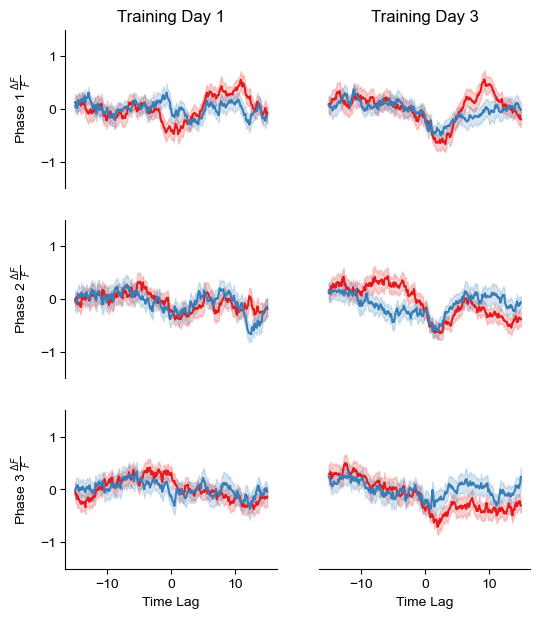

In [53]:
tmp = peri_bout.stack().rename("df").reset_index()
tmp['norm_event'] = tmp.groupby(["day","cs","mouse"], group_keys = False).event.apply(lambda x: x/x.max())
tmp['binned_norm_event'] = pd.cut(tmp.norm_event, bins=nbins)

fig, ax = plt.subplots(nbins,2, figsize = (6,7))
for i,v in enumerate(tmp.binned_norm_event.unique()):
    g = sns.lineplot(tmp.loc[(tmp.day == 1) & (tmp.binned_norm_event == v)],  
                     legend = False, x = 'time', y = 'df', hue = 'cs', ax = ax[i,0], 
                     errorbar = 'se')
    ax[i,0].set_ylim(-1.5,1.5)
    ax[i,0].set_ylabel("Phase " + f"{i+1} " + r"$\frac{\Delta F}{F}$")
    if i<nbins-1: 
        ax[i,0].set_xlabel("")
        ax[i,0].set_xticks([])
        sns.despine(ax = ax[i,0], bottom = True)
    else: 
        ax[i,0].set_xlabel("Time Lag")
        sns.despine(ax = ax[i,0])
    
for i,v in enumerate(tmp.binned_norm_event.unique()):
    g = sns.lineplot(tmp.loc[(tmp.day == 3) & (tmp.binned_norm_event == v)],  
                     x = 'time', y = 'df', hue = 'cs', ax = ax[i,1], 
                     errorbar = 'se', legend = False)
    ax[i,1].set_ylim(-1.5,1.5)
    ax[i,1].set_ylabel("")
    ax[i,1].set_yticks([])
    sns.despine(ax = ax[i,1], left = True, bottom = True)
    if i<nbins-1: 
        ax[i,1].set_xlabel("")
        ax[i,1].set_xticks([])
        sns.despine(ax = ax[i,1], left = True, bottom = True)
    else: 
        ax[i,1].set_xlabel("Time Lag")
        sns.despine(ax = ax[i,1], left = True)
        
ax[0,0].set_title("Training Day 1")
ax[0,1].set_title("Training Day 3")


fig.savefig(os.path.join(peri_stim_pdfs_train , 'within_sess.pdf'), bbox_inches = 'tight')
fig.savefig(os.path.join(peri_stim_svgs_train , 'within_sess.svg'), bbox_inches = 'tight')

##### stats

In [54]:
tmp2 = tmp.groupby(['day','cs','mouse','time','norm_event']).df.mean()
tmp2 = tmp2.reset_index('norm_event')
tmp2['event'] = tmp2['norm_event'].astype(str)
tmp2 = tmp2.set_index('event', append=True).df
tmp2 = tmp2.unstack('time')
tmp2 = bin_peri_bout(tmp2,1).stack().rename("df").reset_index()
tmp2['phase'] = pd.cut(tmp2.event.astype(float), bins=nbins).astype(str)
d1 = tmp2.loc[tmp2.day ==1]
d3 = tmp2.loc[tmp2.day ==3]

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: boundary (singular) fit: see help('isSingular')



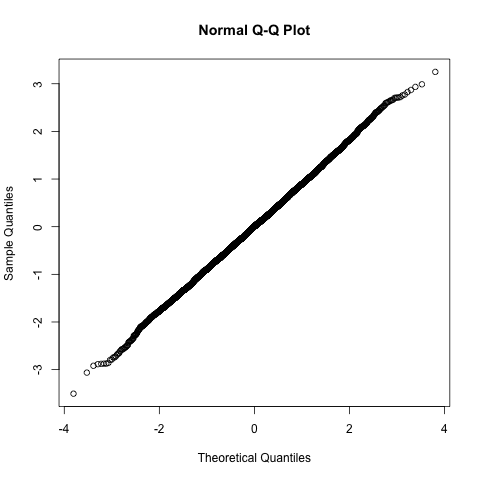

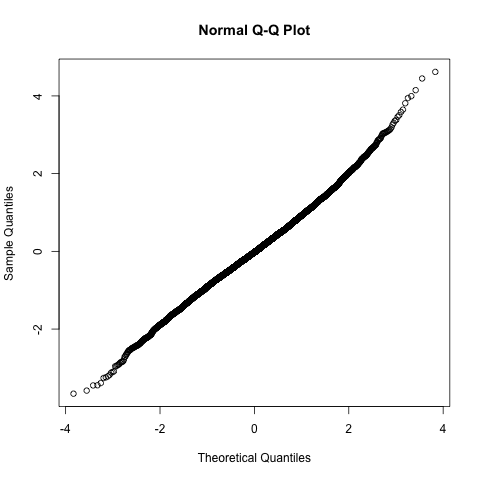

In [55]:
%%R -i d1 -i d3 -o d1_anova_ind -o d1_model_ind -o d3_anova_ind -o d3_model_ind
m <- lmer('df ~ 1 +  factor(cs)*bs(bins, df=8, degree=3)*factor(phase)+ (1 + bs(bins, df=8, degree=3)|mouse)', data = d1)
d1_model_ind <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
d1_anova_ind <- anova(m)

m <- lmer('df ~ 1 +  factor(cs)*bs(bins, df=8, degree=3)*factor(phase)+ (1 + bs(bins, df=8, degree=3)|mouse)', data = d3)
d3_model_ind <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
d3_anova_ind <- anova(m)

In [57]:
within_sess_stats = {
    'd1_anova': d1_anova_ind,
    'd1_model': d1_model_ind,
    'd3_anova': d3_anova_ind,
    'd3_model': d3_model_ind,
}

display(d1_anova_ind)
display(d1_model_ind)
display(d3_anova_ind)
display(d3_model_ind)

with pd.ExcelWriter(os.path.join(stat_save_loc,'within_sess_train_stats.xlsx')) as writer:  
    for k,v in within_sess_stats.items():
        v.to_excel(writer, sheet_name=k)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
factor(cs),1.103473,1.103473,1,3771.015121,1.354045,2.446458e-01
"bs(bins, df = 8, degree = 3)",34.314582,4.289323,8,8.905971,5.263324,1.164381e-02
factor(phase),1.712212,0.856106,2,6986.217191,1.050507,3.498157e-01
"factor(cs):bs(bins, df = 8, degree = 3)",7.839732,0.979966,8,3939.485282,1.202493,2.930536e-01
factor(cs):factor(phase),0.402725,0.201362,2,6986.165582,0.247087,7.810797e-01
"bs(bins, df = 8, degree = 3):factor(phase)",66.445335,4.152833,16,6985.841117,5.095841,1.035072e-10
"factor(cs):bs(bins, df = 8, degree = 3):factor(phase)",36.675807,2.292238,16,6985.814376,2.812750,1.435463e-04


,Estimate,Std. Error,df,t value,Pr(>|t|)
(Intercept),0.126006,0.132693,224.485869,0.949610,0.343332
factor(cs)+,-0.040174,0.189160,6445.973467,-0.212382,0.831816
"bs(bins, df = 8, degree = 3)1",0.134707,0.270455,240.313535,0.498075,0.618887
"bs(bins, df = 8, degree = 3)2",-0.474660,0.220017,101.025309,-2.157377,0.033347
"bs(bins, df = 8, degree = 3)3",0.140783,0.264373,25.113333,0.532516,0.599049
"bs(bins, df = 8, degree = 3)4",-0.193192,0.257656,17.645897,-0.749806,0.463252
"bs(bins, df = 8, degree = 3)5",-0.343741,0.248460,29.745798,-1.383486,0.176812
"bs(bins, df = 8, degree = 3)6",0.252086,0.246405,66.742810,1.023053,0.309977
"bs(bins, df = 8, degree = 3)7",-0.465937,0.257016,54.933716,-1.812875,0.075316
"bs(bins, df = 8, degree = 3)8",-0.193584,0.184210,268.856650,-1.050887,0.294254


,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
factor(cs),1.490695,1.490695,1,7818.786054,1.609329,2.046239e-01
"bs(bins, df = 8, degree = 3)",53.569845,6.696231,8,9.007106,7.229138,3.795272e-03
factor(phase),0.639019,0.319510,2,7827.574835,0.344937,7.082756e-01
"factor(cs):bs(bins, df = 8, degree = 3)",59.728020,7.466002,8,7788.720616,8.060170,6.818159e-11
factor(cs):factor(phase),0.040490,0.020245,2,7827.549645,0.021856,9.783810e-01
"bs(bins, df = 8, degree = 3):factor(phase)",39.382688,2.461418,16,7828.368900,2.657305,3.391880e-04
"factor(cs):bs(bins, df = 8, degree = 3):factor(phase)",63.047058,3.940441,16,7827.957052,4.254034,2.385729e-08


,Estimate,Std. Error,df,t value,Pr(>|t|)
(Intercept),-0.002933,0.141112,166.083856,-0.020782,0.983444
factor(cs)+,0.171652,0.190727,7827.350260,0.899988,0.368154
"bs(bins, df = 8, degree = 3)1",0.445770,0.277054,1023.167734,1.608964,0.107933
"bs(bins, df = 8, degree = 3)2",-0.224687,0.237328,71.823264,-0.946737,0.346947
"bs(bins, df = 8, degree = 3)3",0.373966,0.227140,197.506127,1.646414,0.101269
"bs(bins, df = 8, degree = 3)4",-0.498005,0.239752,31.236920,-2.077166,0.046097
"bs(bins, df = 8, degree = 3)5",-0.186783,0.288219,18.987347,-0.648060,0.524706
"bs(bins, df = 8, degree = 3)6",0.036641,0.277781,35.837176,0.131905,0.895797
"bs(bins, df = 8, degree = 3)7",0.001430,0.270104,44.827357,0.005294,0.995799
"bs(bins, df = 8, degree = 3)8",-0.002377,0.201578,131.811865,-0.011793,0.990609


#### first and last bout

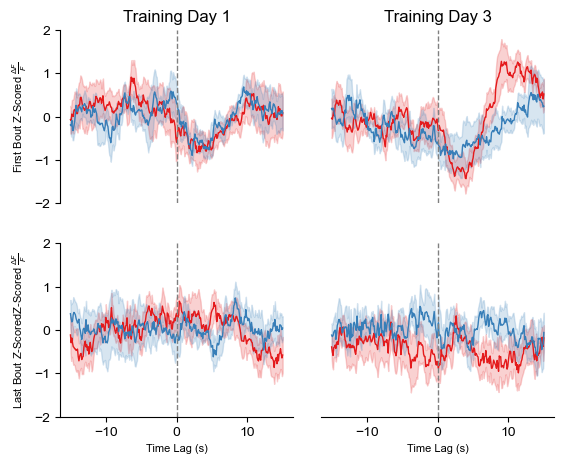

In [156]:
tmp1 = peri_bout.sort_index().loc[:,:,:,0].stack().rename('df').reset_index()
tmp2 = (peri_bout.groupby(['day','cs','mouse'], group_keys = False).apply(lambda x: x.loc[:,:,:,x.index.get_level_values('event').max()])
                 .stack().rename('df').reset_index())



fig, ax = plt.subplots(2,2, figsize = (6,5))
sns.lineplot(data = tmp1.loc[tmp1.day==1], x='time', y='df', 
            errorbar = 'se',  hue='cs', ax = ax[0,0], lw = 1, legend = False)
sns.despine(ax = ax[0,0], bottom = True)
sns.lineplot(data = tmp2.loc[tmp2.day==1], x='time', y='df', 
            errorbar = 'se',  hue='cs', ax = ax[1,0], lw = 1, legend = False)
ax[0,1].set_yticks([])
sns.despine(ax = ax[0,1], left = True, bottom = True)
sns.lineplot(data = tmp1.loc[tmp1.day==3], x='time', y='df', 
            errorbar = 'se',  hue='cs', ax = ax[0,1], lw = 1, legend = False)
sns.despine(ax = ax[1,0])
sns.lineplot(data = tmp2.loc[tmp2.day==3], x='time', y='df', 
            errorbar = 'se',  hue='cs', ax = ax[1,1], lw = 1, legend = False)
ax[1,1].set_yticks([])
sns.despine(ax = ax[1,1], left = True)


ax[0,0].set_title('Training Day 1')
ax[0,1].set_title('Training Day 3')

for i in ax.flatten(): 
    i.set_ylim(-2,2)
    i.axvline(0, c='gray',ls ='--', lw=1)

ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])

ax[1,0].set_xlabel('Time Lag (s)', fontsize = 8)
ax[1,1].set_xlabel('Time Lag (s)', fontsize = 8)

ax[0,0].set_ylabel(r'First Bout Z-Scored $\frac{\Delta F}{F}$', fontsize = 8)
ax[1,0].set_ylabel(r'Last Bout Z-ScoredZ-Scored $\frac{\Delta F}{F}$', fontsize = 8)

ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

fig.tight_layout(pad=2.)
# fig.savefig(os.path.join(peri_stim_pdfs_train , 'training_first_last.pdf'), bbox_inches = 'tight')
# fig.savefig(os.path.join(peri_stim_svgs_train , 'training_first_last.svg'), bbox_inches = 'tight')

# Testing

In [25]:
# load testing data
testing = analysis(norm_method, t_dur, 
                   ds_freq = 1, ex = ex, detrend = detrend, 
                   detrend_method = detrend_method)
testing.load_append_save(cohort1_data_dir/'testing.npy', log=False)
testing.load_append_save(cohort2_data_dir/'testing.npy', log=False)
for i in mice_to_drop:
    testing.remove_mouse(i, recompute = False)

# compute lick bout times for testing
setup = pd.read_csv(os.path.join(data_dir,'setup.csv'), index_col = 0)
for i,v in testing.raw_data.items():
    day = i[0][-1]
    mouse = i[1]
    
    # use setup file to identify left v right licks as cs+ v cs- licks
    csp_s = setup.loc[mouse, f'd{day}_side']
    csm_s = 'left' if csp_s == 'right' else 'right'
    testing.raw_data.loc[i].events['csp'] = v.events[csp_s + '_licks']
    testing.raw_data.loc[i].events['csm'] = v.events[csm_s + '_licks']
    
    # combine cs+ and cs- lick times and construct an array of labels
    cspl = testing.raw_data.loc[i].events['csp']
    csml = testing.raw_data.loc[i].events['csm'] 
    all_licks = np.concatenate((cspl, csml))
    labels = np.array(['p']*cspl.size + ['m']*csml.size)
    
    # sort labels for all lick events so we can identify bouts later
    sort_idx = all_licks.argsort()
    labels = labels[sort_idx]
    all_licks = all_licks[sort_idx]
    testing.raw_data.loc[i].events['all_licks'] = all_licks
    
    # identify bout starts by thresholding the ili over all licks
    ili = np.append(bout_thresh + 1, all_licks[1:] - all_licks[:-1] )
    all_bouts = all_licks[ili>bout_thresh]
    testing.raw_data.loc[i].events['all_bouts'] = all_bouts  
    all_bout_labels = labels[ili>bout_thresh]
    all_bns = get_bn(testing.raw_data.loc[i], 'all_licks', 'all_bouts')
    all_valid_bouts = all_bouts[all_bns>1]
    all_valid_bout_labels = all_bout_labels[all_bns>1]
    all_valid_bout_labels = all_valid_bout_labels[all_valid_bouts<testing.t_endrec - peri_window - 1]
    all_valid_bouts = all_valid_bouts[all_valid_bouts<testing.t_endrec - peri_window - 1]
    testing.raw_data.loc[i].events['all_valid_bouts'] = all_valid_bouts  
    testing.raw_data.loc[i].events['all_valid_bout_labels'] = all_valid_bout_labels

    
    # update the field
    testing.raw_data.loc[i].events['all_csp_bouts'] = all_bouts[all_bout_labels == 'p']
    testing.raw_data.loc[i].events['all_csm_bouts'] = all_bouts[all_bout_labels == 'm']
    testing.raw_data.loc[i].events['csp_bouts'] = all_valid_bouts[all_valid_bout_labels == 'p']
    testing.raw_data.loc[i].events['csm_bouts'] = all_valid_bouts[all_valid_bout_labels == 'm']  

testing_raw_data = deepcopy(testing.raw_data)
testing.compute()

recomputing...
successful


### plot time lock mean traces

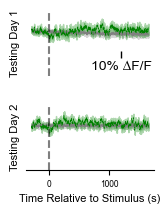

In [26]:
first_lick_test = time_lock_lick(testing, 0)

# create subplot
fig, ax = plt.subplots(2,1, figsize = (2,2.5))
# plot the traces
first_lick_test.plot_both(ax = ax, show = False, linewidth=0.2, c405 = 'gray')
vertbar = AnchoredSizeBar(ax[1].transData,
                           1, '10% ∆F/F', 'lower right', 
                           pad=.1,
                           color='black',
                           frameon=False,
                           size_vertical=.1)
ax[0].add_artist(vertbar)

# format the plots
ax[0].tick_params(left=False,labelleft=False, bottom = False, labelbottom = False)
ax[1].tick_params(left=False,labelleft=False)
for i in ax[1].get_xticklabels():
    i.set_fontsize(6)
sns.despine(ax = ax[0], left = True, bottom = True)
sns.despine(ax = ax[1], left = True)
ax[1].set_ylabel("Testing Day 2", fontsize=8)
ax[1].set_title("")
ax[1].set_ylim(-.6,.3)
ax[0].set_ylabel("Testing Day 1", fontsize=8)
ax[0].set_title("")
ax[0].set_ylim(-.6,.3)
ax[1].xaxis.label.set_fontsize(8)
fig.tight_layout(pad = 2.)

fig.savefig(os.path.join(first_lick_test_pdfs, 'full_trace.pdf'))
fig.savefig(os.path.join(first_lick_test_svgs, 'full_trace.svg'))


## bout level analyses

In [27]:
#reload the data without normalizing
testing = analysis(norm_method, t_dur, norm = False,
                    ds_freq = ds_freq, ex = ex, detrend = detrend, 
                    detrend_method = detrend_method)
testing.raw_data = testing_raw_data
testing.loaded = True
testing.compute()

# remove timestamps corresponding to datapoints that will be lost to the moving average
old_t = testing.all_490.index.values
new_t = old_t[int(ds_freq * w_rad):-int(ds_freq *w_rad)]

# estimate baseline with a moving average
bl = testing.all_490.apply(lambda x: pd.Series(signal.convolve(x, kernel, mode='valid'), index = new_t), axis=0)

# update the end and start time fields in the analysis object
testing.t_prestim = -new_t[0]
testing.t_endrec = new_t[-1]
testing.all_490 = testing.all_490.loc[bl.index]

# normalize relative to the baseline
testing.all_490 = (testing.all_490.copy() - bl)/bl

# #z-score ∆F/Fs relative to baseline activity for each session
testing.all_490 = (testing.all_490 - testing.all_490.loc[:0].mean(axis=0))/testing.all_490.loc[:0].std(axis=0)

recomputing...
successful


In [28]:
# get peri-bout activity for all cs+ and cs- bouts
csp_bout = peri_event(testing, 'csp_bouts', peri_window, norm = peri_bout_norm_test).T
csm_bout = peri_event(testing, 'csm_bouts', peri_window, norm = peri_bout_norm_test).T

# combine into one dataframe
peri_test_all = pd.concat({'+':csp_bout, '-':csm_bout}, names = ['cs'])
peri_test_all.columns.name = 'time'

# some reformatting for easier access
peri_test_all = peri_test_all.stack().rename('df').reset_index()
peri_test_all['day'] = peri_test_all.cond.str.extract('_(.)').astype(int)
peri_test_all = peri_test_all.set_index(['day','cs','mouse', 'event', 'time']).df.unstack('time')

# select only mice that had at least 3 bouts for each flavor on both days
nb_test = peri_test_all.groupby(['cs','day','mouse']).size().unstack(['cs','day'])
good_mice = (nb_test>=3).all(axis=1)
good_mice = good_mice.loc[good_mice].index
nb_test = nb_test.loc[good_mice].stack(['cs','day'])
peri_test = (peri_test_all.swaplevel('day','mouse')
                      .loc[good_mice]
                      .swaplevel('day','mouse')
            )

# get mean response
mn_peri_test_all = peri_test_all.groupby(['day','cs','mouse']).mean()
mn_peri_test_all = (mn_peri_test_all.unstack(['day','cs'])
                            .dropna()
                            .stack(['cs', 'day'])
                            .swaplevel('mouse','day')
                            .sort_index()
               )

mn_peri_test = peri_test.groupby(['day','cs','mouse']).mean()
mn_peri_test = (mn_peri_test.unstack(['day','cs'])
                            .dropna()
                            .stack(['cs', 'day'])
                            .swaplevel('mouse','day')
                            .sort_index()
               )

In [29]:
# check how many bouts we are removing due to the moving average
max_rm_bouts = testing.raw_data.map(lambda x: (x.events['all_bouts']>testing.t_endrec).sum()).max()
mn_rm_bouts = testing.raw_data.map(lambda x: (x.events['all_bouts']>testing.t_endrec).sum()).mean()
print('max removed bouts:', max_rm_bouts , '\nmn_rm_bouts:', mn_rm_bouts)

max removed bouts: 1 
mn_rm_bouts: 0.35714285714285715


In [30]:
# seed the random number generator for random bout generation
np.random.seed(5)

# simmulate random lick bouts and get corresponding peri bout activity
ctl_test = []

with tqdm(total = niters_rand) as pbar:
    def randomize_test_bouts(pid):
        global ctl_test
        global testing
        end_lim = testing.all_490.index[-1]-peri_window-1
        for i,v in testing.raw_data.items():
            # create an array of times to sample
            ts = np.arange(0, end_lim + 1/100, step = 1/100)
            n = v.events['all_bouts'].size # get the number of bouts to sample
            rand_evs = np.empty((n,))
            for j in range(n):
                #choose a bout onset time from available times
                rand_evs[j] = np.random.choice(ts)
                # remove the selected time from avavilable times array
                # as well as any times within the bout threshold
                ts = ts[np.abs(ts - rand_evs[j]) > bout_thresh]  
            rand_evs = np.sort(rand_evs) 
            # sample appropriate number of cs+ bouts
            csp = np.random.choice(rand_evs, v.events['all_csp_bouts'].size, replace = False)
            rand_evs = rand_evs[~np.isin(rand_evs, csp)]
            csp = np.random.choice(csp, v.events['csp_bouts'].size, replace = False)

            # sample appropriate number of cs- bouts
            csm = np.random.choice(rand_evs, v.events['all_csm_bouts'].size, replace = False)
            csm = np.random.choice(csm, v.events['csm_bouts'].size, replace = False)

            #save randomized bouts
            testing.raw_data.loc[i].events[f'rand_csp_{pid}'] = csp
            testing.raw_data.loc[i].events[f'rand_csm_{pid}'] = csp

        # get peri-bout data for random bouts and compute the mean response
        _d = pd.concat({'+': peri_event(testing, f'rand_csp_{pid}',  
                                        peri_window, 
                                        norm = peri_bout_norm_test).groupby(['cond','mouse'], axis=1).mean(),
                        '-': peri_event(testing, f'rand_csm_{pid}', 
                                        peri_window, 
                                        norm = peri_bout_norm_test).groupby(['cond','mouse'], axis=1).mean()
                       }, names = ['cs','time'])
        

        ctl_test.append(_d)


    with ThreadPoolExecutor(max_workers=2) as pool:
        futures = [pool.submit(randomize_test_bouts, i) for i in range(niters_rand)]
        for future in as_completed(futures):
            pbar.update(1)
        
ctl_test = pd.concat(dict(enumerate(ctl_test)), axis=1, names = ['event'])
ctl_test = ctl_test.unstack('cs').T.reset_index()
ctl_test['day']= ctl_test.cond.str.extract('_(.)').astype(int)
ctl_test=ctl_test.set_index(['day','cs','mouse','event']).drop('cond', axis=1).sort_index()
ctl_test_mn = ctl_test.groupby(['day','cs','mouse']).mean()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.76it/s]


### plot testing preference

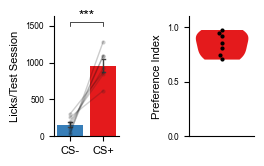

In [31]:
def get_cs_licks(x):
    x = x.iloc[0]
    return pd.Series([x.events['csp'].size, x.events['csm'].size], 
                     index = pd.Index(('+', '-'), name = 'CS'))
def get_cs_bursts(x):
    x = x.iloc[0]
    csp_ili = np.append(1, x.events['csp'][1:] - x.events['csp'][:-1])
    csm_ili = np.append(1, x.events['csm'][1:] - x.events['csm'][:-1])
    return pd.Series([(csp_ili>0.5).sum(), (csm_ili>0.5).sum()], 
                     index = pd.Index(('+', '-'), name = 'CS'))

# get testing licks for plot
test_licks = testing.raw_data.groupby(['cond','mouse']).apply(get_cs_licks).rename('total_licks').reset_index()
test_licks = test_licks.groupby(['mouse','CS']).total_licks.mean().unstack('CS')

# compute preference
pref = test_licks['+']/(test_licks['+'] + test_licks['-'])
test_lick_stat  = st.ttest_rel(test_licks['+'], test_licks['-'])
test_licks = test_licks.stack().rename('total_licks').reset_index()

test_licks['csp'] = test_licks.CS=='+'

fig, ax = plt.subplots(1,2, figsize = (3,2))
sns.barplot(data = test_licks, x='CS', y = 'total_licks', order = ['-', '+'], saturation = 1,
            ax = ax[0], errorbar = 'se', palette = sns.color_palette('Set1', 2)[::-1],
            capsize = .1, errwidth = 1)
sns.lineplot(data = test_licks, x='csp', y = 'total_licks',  ax = ax[0], hue='mouse', 
             palette = 'dark:k', marker = 'o', markeredgewidth = 0, lw = 1, alpha = 0.2,
            legend=False, ms = 3)
ax[0].set_xticklabels(['CS-', 'CS+'], fontsize = 8)
ax[0].set_xlabel('')
ax[0].set_ylabel('Licks/Test Session', fontsize = 8)
plot_significance(test_lick_stat.pvalue, ax[0], 0, 1, 1500, 50)


sns.swarmplot(pref, color = 'k', ax = ax[1], s = 3)
sns.violinplot(pref, linewidth = 0, cut = 0,  ax = ax[1], saturation = 1)
ax[1].set_xticks([])
ax[1].set_ylabel('Preference Index', fontsize = 8)
ax[1].set_ylim(0, 1.1)

for j in ax[0].get_yticklabels() + ax[1].get_yticklabels():
    j.set_fontsize(6)

sns.despine()
fig.tight_layout(pad = 2.)

fig.savefig(os.path.join(peri_stim_pdfs_test , 'test_pref.pdf'), bbox_inches = 'tight')
fig.savefig(os.path.join(peri_stim_svgs_test , 'test_pref.svg'), bbox_inches = 'tight')

#### stats

In [78]:
test_lick_stat = pd.Series(list(test_lick_stat) + [test_lick_stat.df], index = ('t', 'p-value', 'df'), name = 't-test').to_frame().T
test_lick_stat['Significance'] = test_lick_stat['p-value'].apply(check_significance)

display(test_lick_stat)
test_fig_stats.update({'b_test_lick_stats': test_lick_stat})

,t,p-value,df,Significance
t-test,6.857105,0.000474,6.0,***


### plot bout-triggered averages

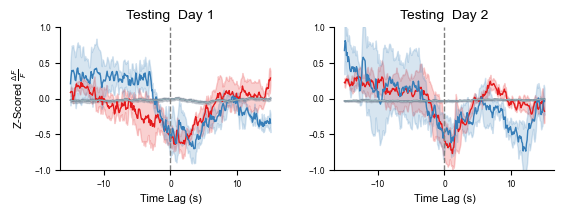

In [32]:
tmp = mn_peri_test.stack().rename('df')
tmp2 = ctl_test_mn.stack().rename('df')


fig, ax = plt.subplots(1,2, figsize = (6,2.5))
for i,j in enumerate([1,2]):
    sns.lineplot(data = tmp.loc[j].reset_index(), x='time', y='df', 
                 errorbar = 'se',  hue='cs', ax = ax[i], lw = 1, legend = False)
    sns.lineplot(data = tmp2.loc[j].reset_index(), x='time', y='df', 
                 errorbar = 'se',  hue='cs', ax = ax[i], lw = 1,
                 legend = False, palette='bone')
    ax[i].set_ylim(-1,1)
    ax[i].set_xlabel('Time Lag (s)', fontsize = 8)
    ax[i].axvline(0, c='gray',ls ='--', lw=1)
    for k in ax[i].get_xticklabels() + ax[i].get_yticklabels():
        k.set_fontsize(6)
    ax[i].set_title(f'Testing  Day {j}', fontsize=10)
    
ax[0].set_ylabel(r'Z-Scored $\frac{\Delta F}{F}$', fontsize = 8)
ax[1].set_ylabel('')
sns.despine()
fig.tight_layout(pad=2.)

fig.savefig(os.path.join(peri_stim_pdfs_test ,'test_peri.pdf'))
fig.savefig(os.path.join(peri_stim_svgs_test ,'test_peri.svg'))


#### individual mice

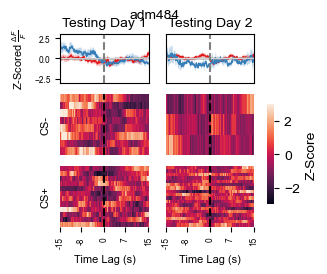

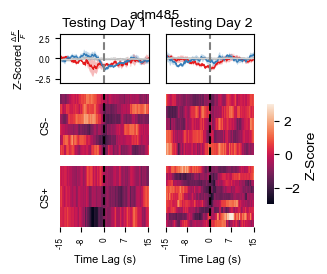

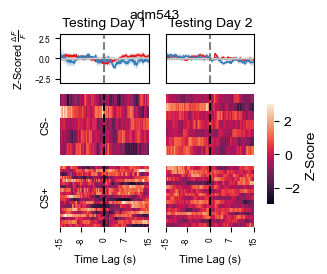

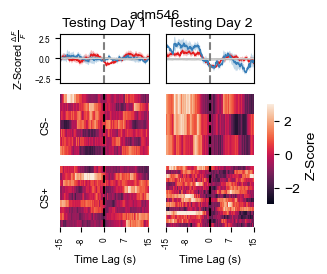

In [33]:
for i in mn_peri_test.index.get_level_values('mouse').unique():
    fig, ax = plot_peri(peri_test.swaplevel('day','mouse').loc[i].swaplevel('day','cs'), 
                        ctl_test.swaplevel('day','mouse').loc[i].swaplevel('day','cs'),
                        'Testing', save=False, vmin = -3, vmax=3, ylim = (-3,3), 
                        figsize=(2.5,2.5));
    for l in range(2):
        for j in range(3):
            for k in ax[j,l].get_xticklabels() + ax[j,l].get_yticklabels():
                k.set_fontsize(6)
            ax[j,l].xaxis.label.set_fontsize(8)
            ax[j,l].yaxis.label.set_fontsize(8)
            ax[j,l].title.set_fontsize(10)
            
    fig.suptitle(i, fontsize=10)    
    os.makedirs(os.path.join(peri_stim_pdfs_test , i), exist_ok=True)  
    os.makedirs(os.path.join(peri_stim_svgs_test , i), exist_ok=True)   

    fig.savefig(os.path.join(peri_stim_pdfs_test , i,  'test_peri.pdf'), bbox_inches = 'tight')
    fig.savefig(os.path.join(peri_stim_svgs_test , i, 'test_peri.svg'), bbox_inches = 'tight')


#### stats

##### stats - compare lick bouts to be sure the corresponding bout numbers for all bout triggered averages are comparable

In [44]:
nbouts = (nb_test.groupby(['day','cs']).mean().round(2).astype(str) + ' ± ' + nb_test.groupby(['day','cs']).sem().round(2).astype(str)).rename('bout number').to_frame()
display(nbouts)
test_fig_stats.update({'e_n_bouts': nbouts})

bout number
day cs              
1   +   10.75 ± 3.33
    -     6.5 ± 0.65
2   +    14.5 ± 1.94
    -    4.25 ± 0.75

##### stats - compare bout triggered averages

In [45]:
peri_test_binned = bin_peri_bout(peri_test, 1).stack().rename('df').reset_index()

R[write to console]: boundary (singular) fit: see help('isSingular')



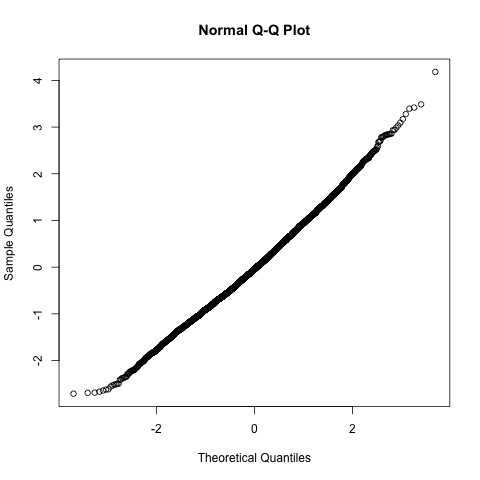

In [46]:
%%R -i peri_test_binned  -o test_anova  -o test_model
m <- lmer('df ~ 1 + factor(day)*bs(bins, df=8,degree=3)*factor(cs) + (1 + bs(bins, df=8,degree=3)|mouse)', data = peri_test_binned)
test_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
test_anova <- anova(m)


In [47]:
test_anova['Significance'] = test_anova['Pr(>F)'].apply(check_significance)
test_model['Significance'] = test_model['Pr(>|t|)'].apply(check_significance)

display(test_anova, test_model)
test_fig_stats.update({'e_test_anova_trace': test_anova,
                       'e_test_model' : test_model
                     })

with pd.ExcelWriter(os.path.join(stat_save_loc,'test_stats.xlsx')) as writer:  
    for k,v in test_fig_stats.items():
        v.to_excel(writer, sheet_name=k)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F),Significance
factor(day),0.392425,0.392425,1,4399.019652,0.445361,5.045812e-01,ns
"bs(bins, df = 8, degree = 3)",38.078826,4.759853,8,5.651614,5.401940,3.094964e-02,*
factor(cs),2.984213,2.984213,1,4093.713872,3.386773,6.579382e-02,ns
"factor(day):bs(bins, df = 8, degree = 3)",17.699272,2.212409,8,4401.153623,2.510855,1.013073e-02,*
factor(day):factor(cs),0.000015,0.000015,1,4169.196709,0.000018,9.966575e-01,ns
"bs(bins, df = 8, degree = 3):factor(cs)",44.834091,5.604261,8,4117.434244,6.360255,3.123503e-08,****
"factor(day):bs(bins, df = 8, degree = 3):factor(cs)",17.795413,2.224427,8,4220.048966,2.524494,9.739898e-03,**


,Estimate,Std. Error,df,t value,Pr(>|t|),Significance
(Intercept),0.357572,0.184982,43.111034,1.933013,0.059820,ns
factor(day)2,0.108642,0.275408,4347.507501,0.394478,0.693248,ns
"bs(bins, df = 8, degree = 3)1",0.163194,0.370422,59.094434,0.440564,0.661136,ns
"bs(bins, df = 8, degree = 3)2",-0.208396,0.280695,485.909674,-0.742431,0.458185,ns
"bs(bins, df = 8, degree = 3)3",0.215772,0.328241,19.960399,0.657357,0.518460,ns
"bs(bins, df = 8, degree = 3)4",-1.091780,0.335447,10.827284,-3.254705,0.007824,**
"bs(bins, df = 8, degree = 3)5",-0.773805,0.288597,60.574386,-2.681268,0.009437,**
"bs(bins, df = 8, degree = 3)6",-0.124742,0.310467,162.052211,-0.401788,0.688369,ns
"bs(bins, df = 8, degree = 3)7",-0.891646,0.316558,115.594019,-2.816688,0.005708,**
"bs(bins, df = 8, degree = 3)8",-0.694275,0.272260,25.949221,-2.550047,0.017022,*


### First and last bouts

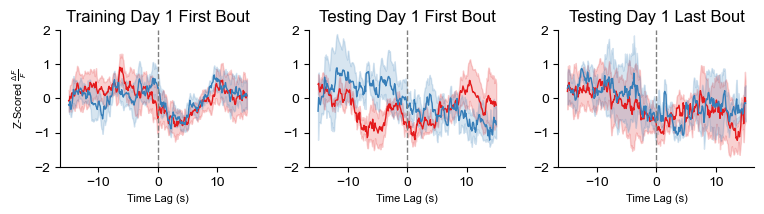

In [34]:
tmp1 = peri_test.sort_index().loc[1,:,:,0].stack().rename('df').reset_index()
tmp2 = (peri_test.loc[1].groupby(['cs','mouse'], group_keys = False).apply(lambda x: x.loc[:,:,x.index.get_level_values('event').max()])
                 .stack().rename('df').reset_index())
tmp3 = peri_bout.sort_index().loc[1,:,:,0].stack().rename('df').reset_index()

fig, ax = plt.subplots(1,3, figsize = (8,2.5))
sns.lineplot(data = tmp3, x='time', y='df', 
            errorbar = 'se',  hue='cs', ax = ax[0], lw = 1, legend = False)
sns.lineplot(data = tmp1, x='time', y='df', 
            errorbar = 'se',  hue='cs', ax = ax[1], lw = 1, legend = False)
sns.lineplot(data = tmp2, x='time', y='df', 
            errorbar = 'se',  hue='cs', ax = ax[2], lw = 1, legend = False)

for i in range(3): 
    ax[i].set_ylim(-2,2)
    ax[i].set_xlabel('Time Lag (s)', fontsize = 8)
    ax[i].axvline(0, c='gray',ls ='--', lw=1)

ax[0].set_title('Training Day 1 First Bout')
ax[1].set_title('Testing Day 1 First Bout')
ax[2].set_title('Testing Day 1 Last Bout')



ax[0].set_ylabel(r'Z-Scored $\frac{\Delta F}{F}$', fontsize = 8)
ax[1].set_ylabel('')
ax[2].set_ylabel('')


sns.despine()
fig.tight_layout(pad=2.)


fig.savefig(os.path.join(peri_stim_pdfs_test , 'within_sess.pdf'), bbox_inches = 'tight')
fig.savefig(os.path.join(peri_stim_svgs_test , 'within_sess.svg'), bbox_inches = 'tight')

In [82]:
tmp4 = pd.concat({'b-test-first': tmp1, 'c-test-last': tmp2, 'a-train-first': tmp3}, names = ['event']).reset_index()
tmp4['day'] = 1
tmp4 = tmp4.set_index(['day','cs','mouse','event', 'time']).df.unstack('time')
tmp4 = bin_peri_bout(tmp4, 1).stack().rename('df').reset_index()

tr1 = tmp4.loc[tmp4.event == 'a-train-first']
t1 = tmp4.loc[tmp4.event == 'b-test-first']
t2 = tmp4.loc[tmp4.event == 'c-test-last']

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: boundary (singular) fit: see help('isSingular')



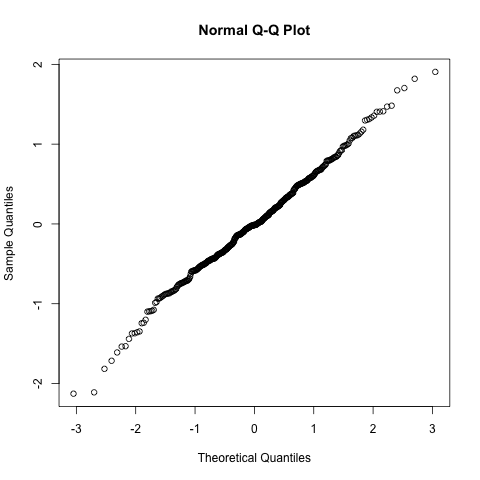

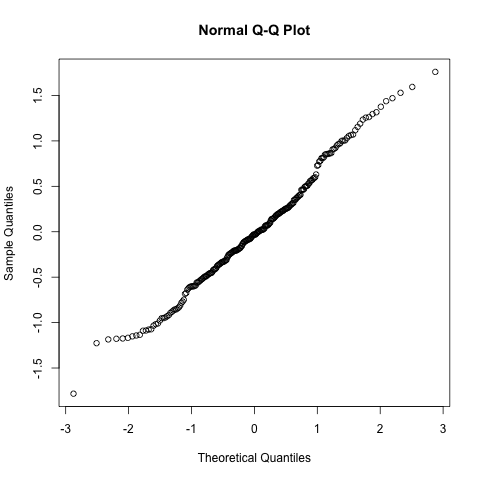

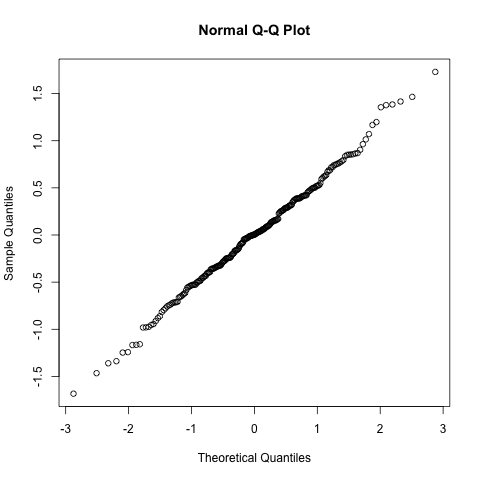

In [83]:
%%R -i tr1 -o train_first_anova  -o train_first_model -i t1 -o test_first_anova  -o test_first_model -i t2 -o test_last_anova  -o test_last_model
m <- lmer('df ~ 1 +  bs(bins, df=8,degree=3)*factor(cs) + (1 + bs(bins, df=8,degree=3)|mouse)', data = tr1)
train_first_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
train_first_anova <- anova(m)

m <- lmer('df ~ 1 +  bs(bins, df=8,degree=3)*factor(cs) + (1 + bs(bins, df=8,degree=3)|mouse)', data = t1)
test_first_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
test_first_anova <- anova(m)

m <- lmer('df ~ 1 +  bs(bins, df=8,degree=3)*factor(cs) + (1 + bs(bins, df=8,degree=3)|mouse)', data = t2)
test_last_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
test_last_anova <- anova(m)


In [99]:
within_sess_test_stats = {
    'train_first_anova': train_first_anova,
    'train_first_model': train_first_model,
    'test_first_anova': test_first_anova,
    'test_first_model': test_first_model,
    'test_last_anova': test_last_anova,
    'test_last_model': test_last_model
}

display(train_first_anova)
display(test_first_anova)
display(test_last_anova)

display(train_first_model)
display(test_first_model)
display(test_last_model)

with pd.ExcelWriter(os.path.join(stat_save_loc,'within_test_stats.xlsx')) as writer:  
    for k,v in within_sess_test.items():
        v.to_excel(writer, sheet_name=k)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
"bs(bins, df = 8, degree = 3)",9.589802,1.198725,8,7.877015,2.638827,0.097245
factor(cs),0.046277,0.046277,1,379.997914,0.101872,0.749770
"bs(bins, df = 8, degree = 3):factor(cs)",5.169362,0.646170,8,379.997919,1.422454,0.185237


,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
"bs(bins, df = 8, degree = 3)",8.677196,1.084649,8,5.847968,2.332546,1.622153e-01
factor(cs),0.259304,0.259304,1,220.997526,0.557634,4.560088e-01
"bs(bins, df = 8, degree = 3):factor(cs)",25.304417,3.163052,8,220.997528,6.802165,5.585443e-08


,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
"bs(bins, df = 8, degree = 3)",11.880138,1.485017,8,5.115713,4.029887,0.068304
factor(cs),0.012747,0.012747,1,220.981182,0.034592,0.852625
"bs(bins, df = 8, degree = 3):factor(cs)",2.083575,0.260447,8,220.981184,0.706774,0.685432


,Estimate,Std. Error,df,t value,Pr(>|t|)
(Intercept),-0.035205,0.341873,11.099536,-0.102976,0.919819
"bs(bins, df = 8, degree = 3)1",0.380192,0.654009,13.367654,0.581325,0.570694
"bs(bins, df = 8, degree = 3)2",-0.488684,0.466772,17.922556,-1.046944,0.309040
"bs(bins, df = 8, degree = 3)3",0.536233,0.582746,10.337766,0.920184,0.378449
"bs(bins, df = 8, degree = 3)4",0.111221,0.672763,8.169981,0.165320,0.872710
"bs(bins, df = 8, degree = 3)5",-1.076255,0.545880,10.524596,-1.971595,0.075508
"bs(bins, df = 8, degree = 3)6",1.311479,0.540241,13.934107,2.427582,0.029351
"bs(bins, df = 8, degree = 3)7",-0.264017,0.675303,9.555091,-0.390961,0.704401
"bs(bins, df = 8, degree = 3)8",0.164812,0.591024,8.787178,0.278858,0.786805
factor(cs)+,0.108084,0.338637,379.997914,0.319174,0.749770


,Estimate,Std. Error,df,t value,Pr(>|t|)
(Intercept),-0.102544,0.379750,10.150094,-0.270030,0.792548
"bs(bins, df = 8, degree = 3)1",1.030049,0.916748,6.089025,1.123590,0.303524
"bs(bins, df = 8, degree = 3)2",0.271819,0.627406,9.138461,0.433243,0.674885
"bs(bins, df = 8, degree = 3)3",0.798856,0.876582,4.623090,0.911331,0.407130
"bs(bins, df = 8, degree = 3)4",-0.271175,0.572421,8.923931,-0.473733,0.647065
"bs(bins, df = 8, degree = 3)5",-0.222760,0.567768,13.778479,-0.392343,0.700807
"bs(bins, df = 8, degree = 3)6",-0.400915,0.650861,11.650959,-0.615976,0.549755
"bs(bins, df = 8, degree = 3)7",-0.882167,0.706707,8.380333,-1.248278,0.245675
"bs(bins, df = 8, degree = 3)8",-0.656714,0.530024,10.803128,-1.239028,0.241579
factor(cs)+,0.338457,0.453241,220.997526,0.746749,0.456009


,Estimate,Std. Error,df,t value,Pr(>|t|)
(Intercept),0.181769,0.330816,11.258777,0.549457,0.593423
"bs(bins, df = 8, degree = 3)1",0.520360,0.628540,19.677725,0.827887,0.417663
"bs(bins, df = 8, degree = 3)2",-0.015138,0.559786,9.012788,-0.027042,0.979015
"bs(bins, df = 8, degree = 3)3",0.198505,1.148070,3.603762,0.172903,0.871997
"bs(bins, df = 8, degree = 3)4",-0.889291,0.480873,11.748445,-1.849325,0.089715
"bs(bins, df = 8, degree = 3)5",-0.852753,0.788543,4.386238,-1.081429,0.335344
"bs(bins, df = 8, degree = 3)6",0.119184,1.346177,3.460883,0.088535,0.934332
"bs(bins, df = 8, degree = 3)7",-0.881352,0.562639,15.053534,-1.566461,0.138017
"bs(bins, df = 8, degree = 3)8",-0.299176,0.620624,5.073566,-0.482056,0.649843
factor(cs)+,0.075042,0.403477,220.981182,0.185988,0.852625
